# Characterize Mercer, Novel, All BPs

For each group plot:
- Phastcons
- PhyloP
- Distance from 3'ss
- PWM

both seperately and all on one plot.

In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        gene = gene.split(':')[-1]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

37110
169182
('chr16', 70399987, '+', 'RP11-529K1.3')


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known, phastcons, phylop)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing, phastcons, phylop)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 6) (37110, 70, 6)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [8]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [9]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

## Conservation Meta

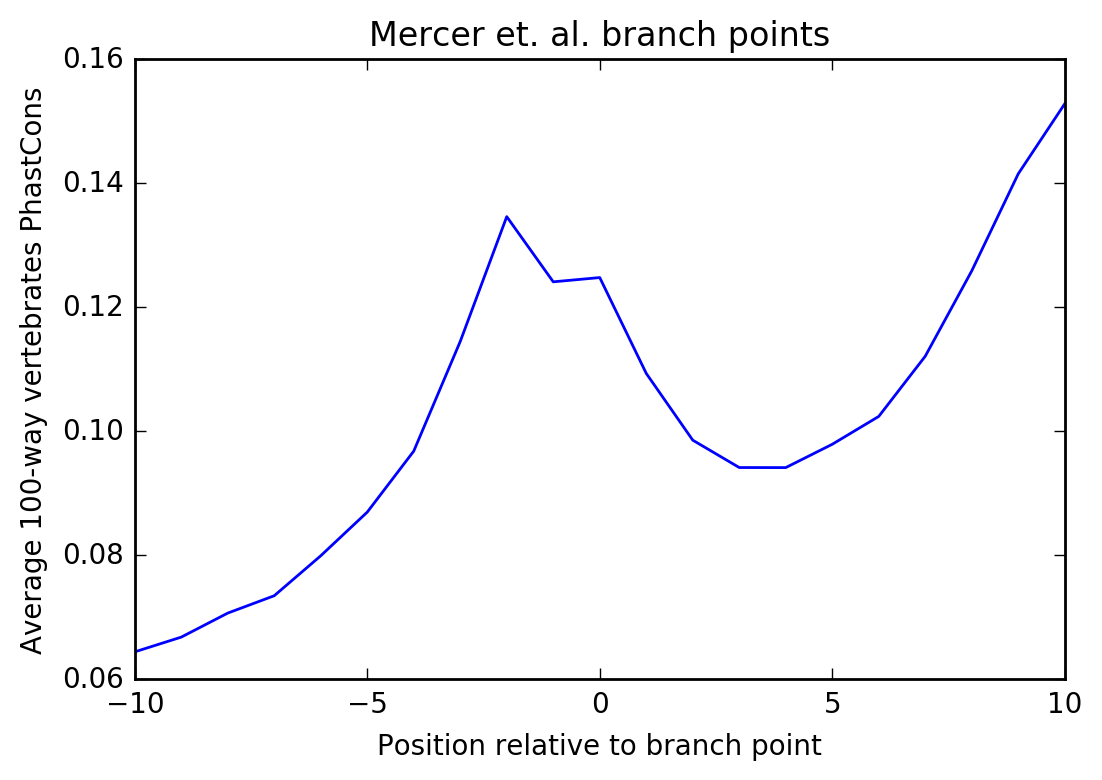

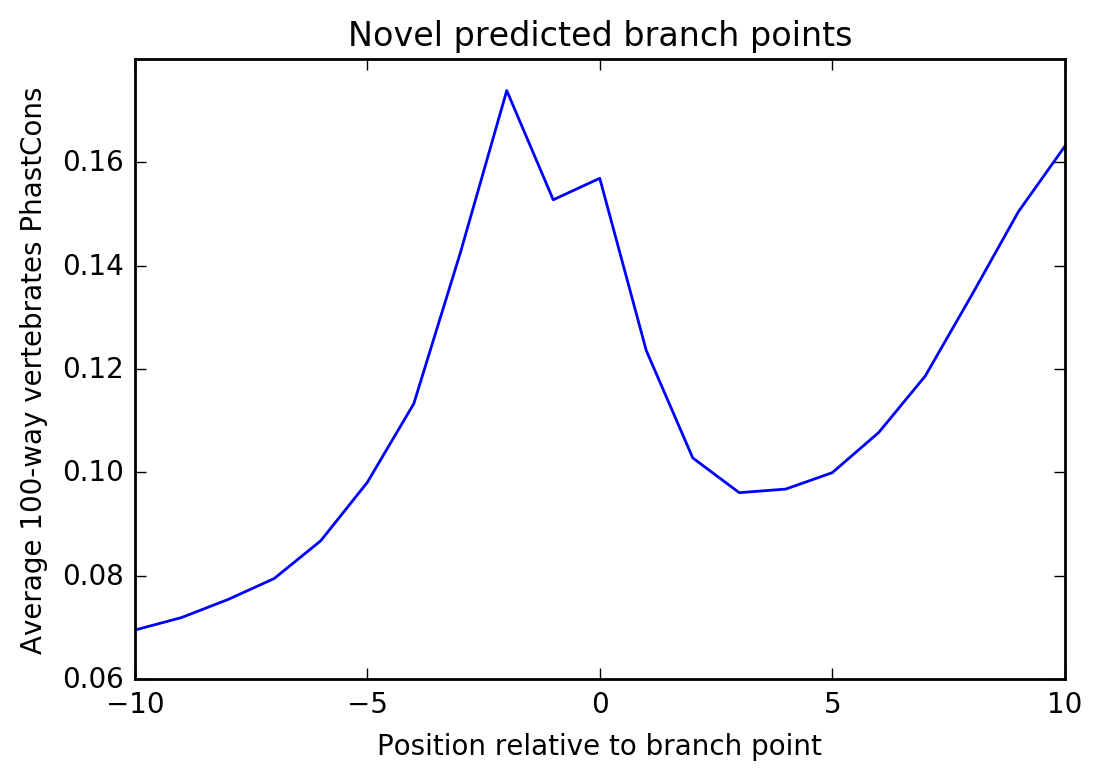

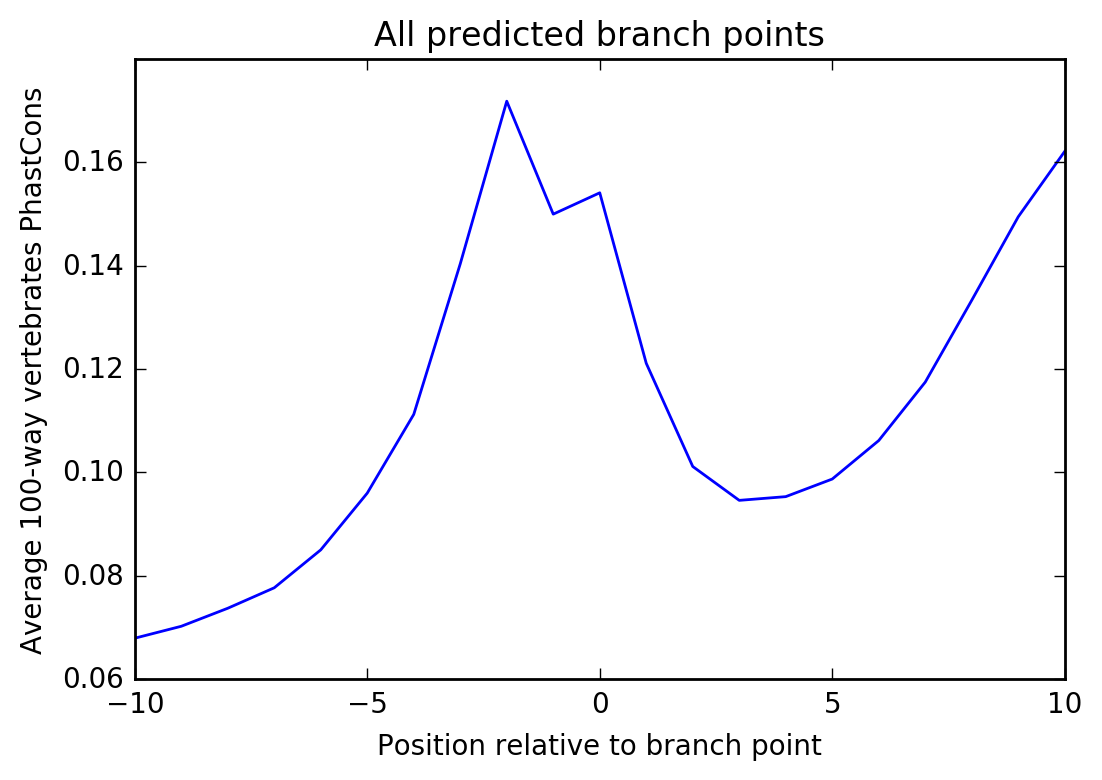

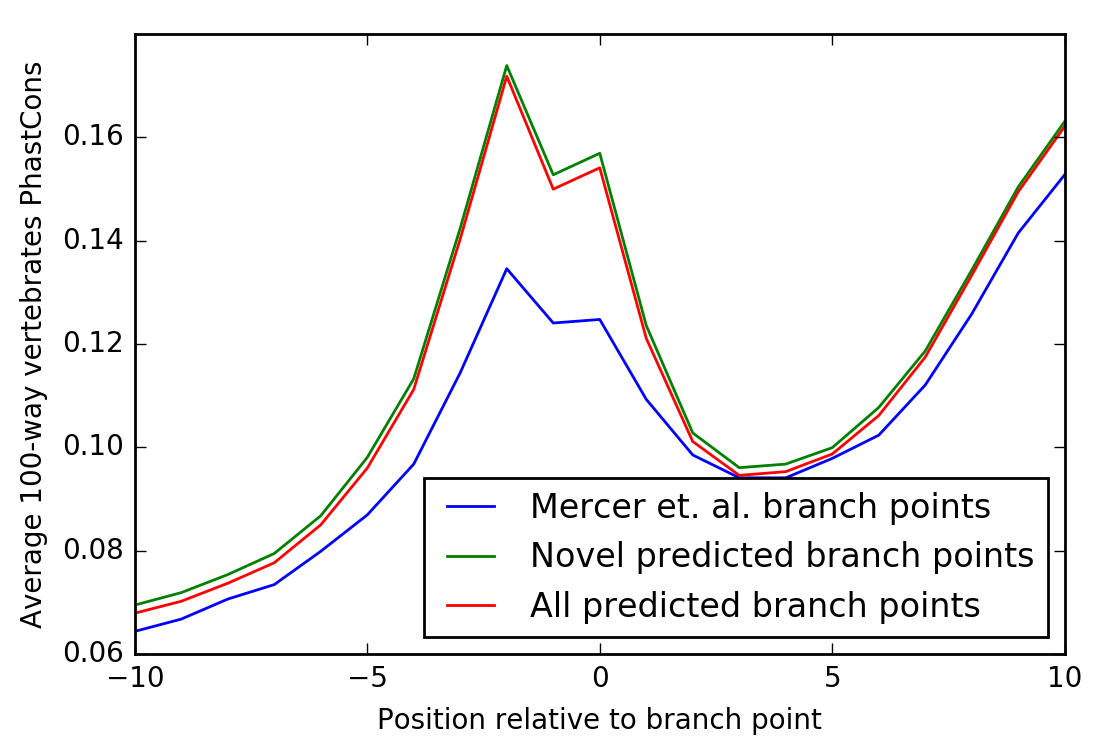

In [10]:
K = 10

def cons_known(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    return counts / total

def cons_novel(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, idx]
        total += 1
    return counts / total

known = cons_known(X_known, y_known, 4)
novel = cons_novel(X_novel, y_novel, 4)
allbp = cons_novel(X_all,   y_all,   4)

names = ['Mercer et. al. branch points',
         'Novel predicted branch points',
         'All predicted branch points']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
plt.legend(loc = 'best')
plt.show()

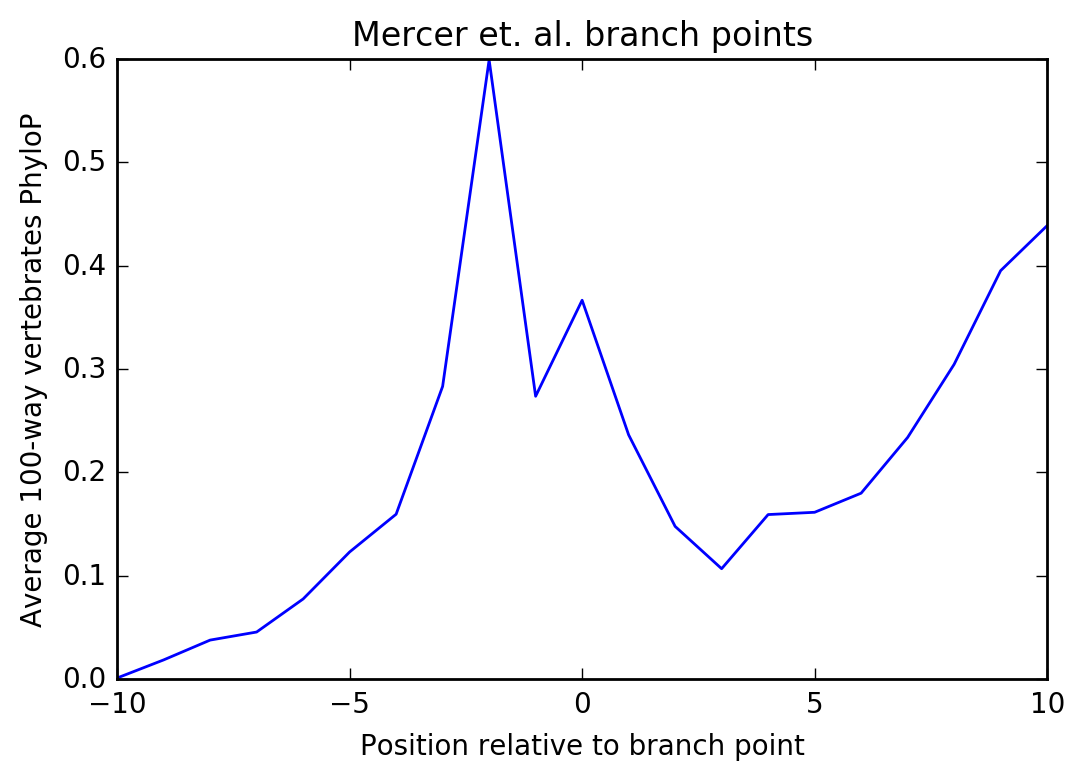

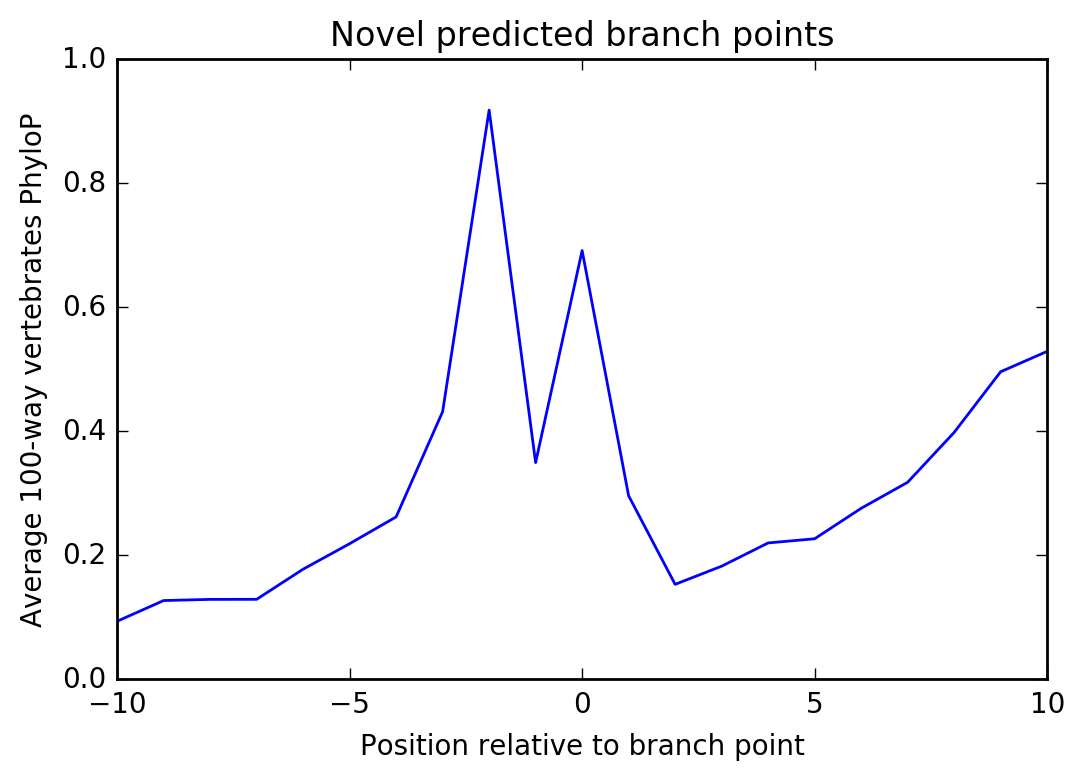

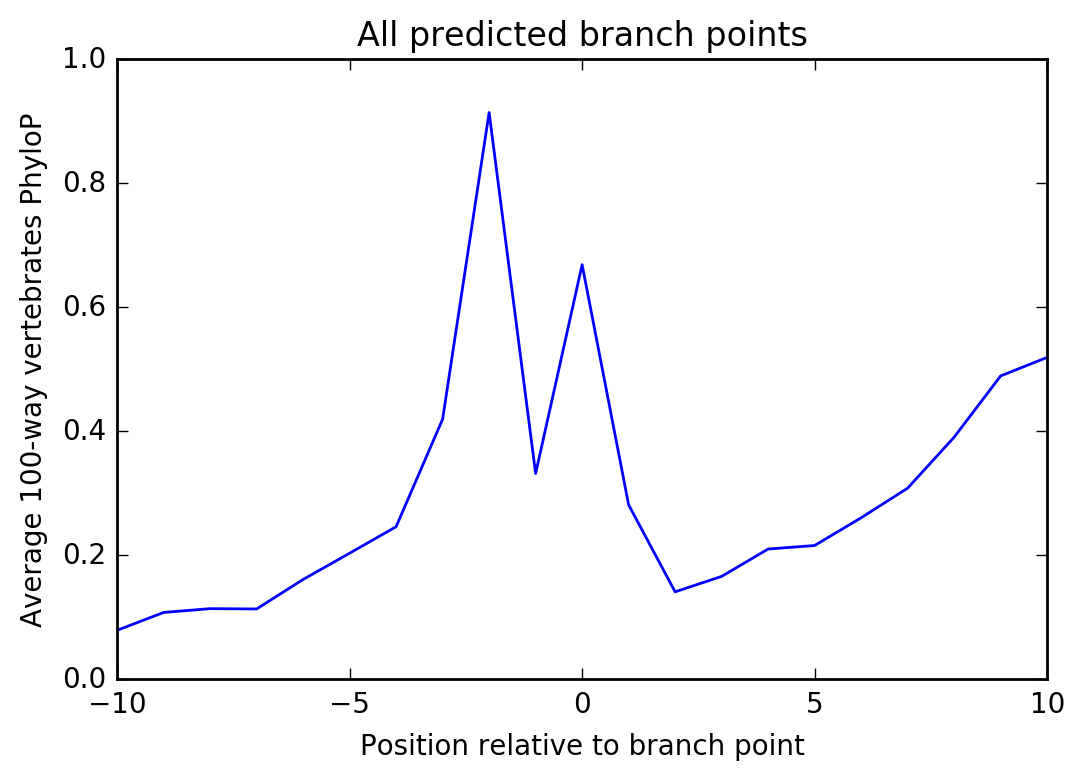

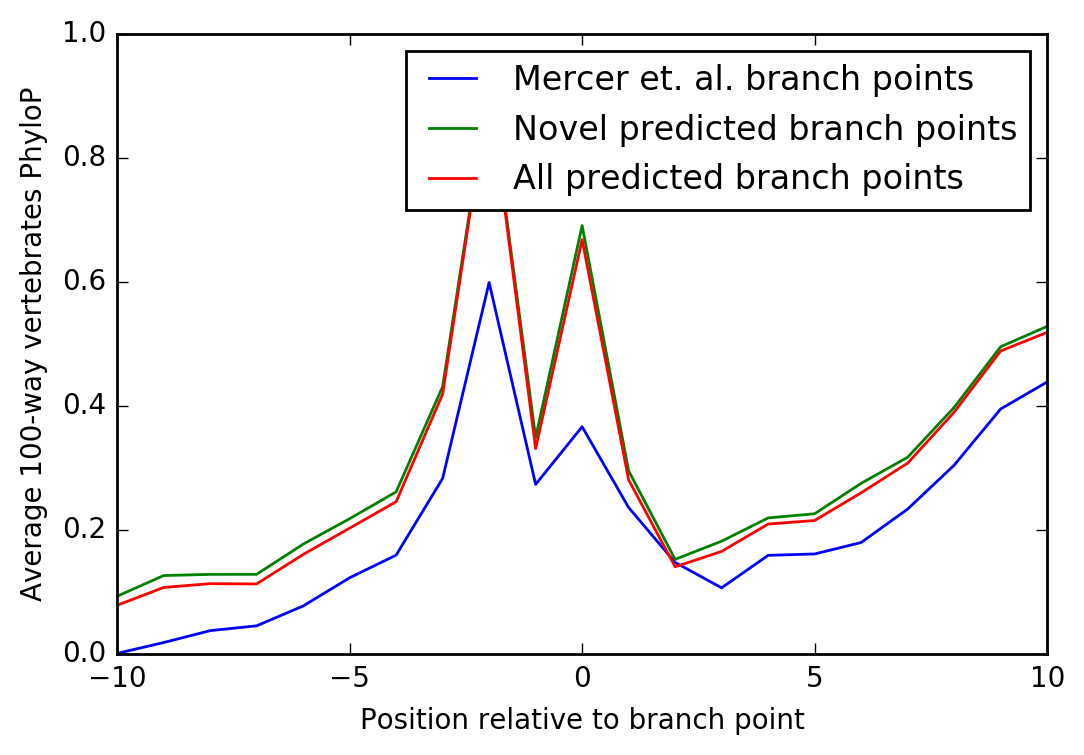

In [11]:
known = cons_known(X_known, y_known, 5)
novel = cons_novel(X_novel, y_novel, 5)
allbp = cons_novel(X_all,   y_all,   5)

names = ['Mercer et. al. branch points',
         'Novel predicted branch points',
         'All predicted branch points']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()

202549


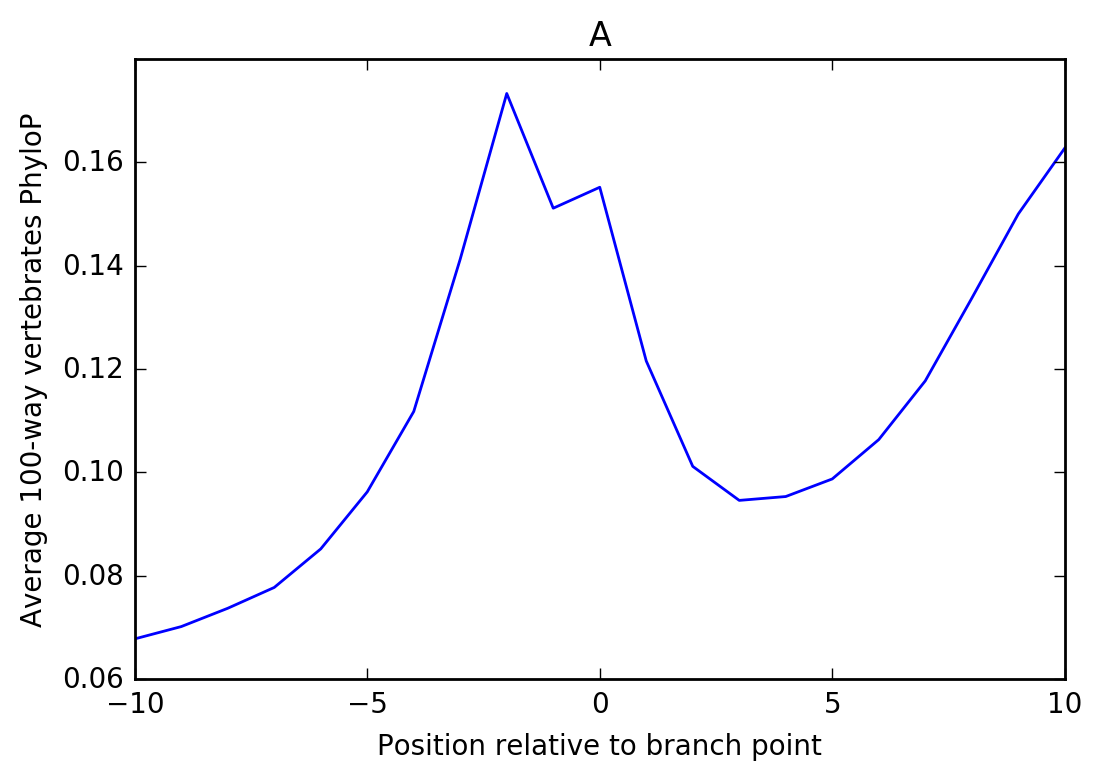

3347


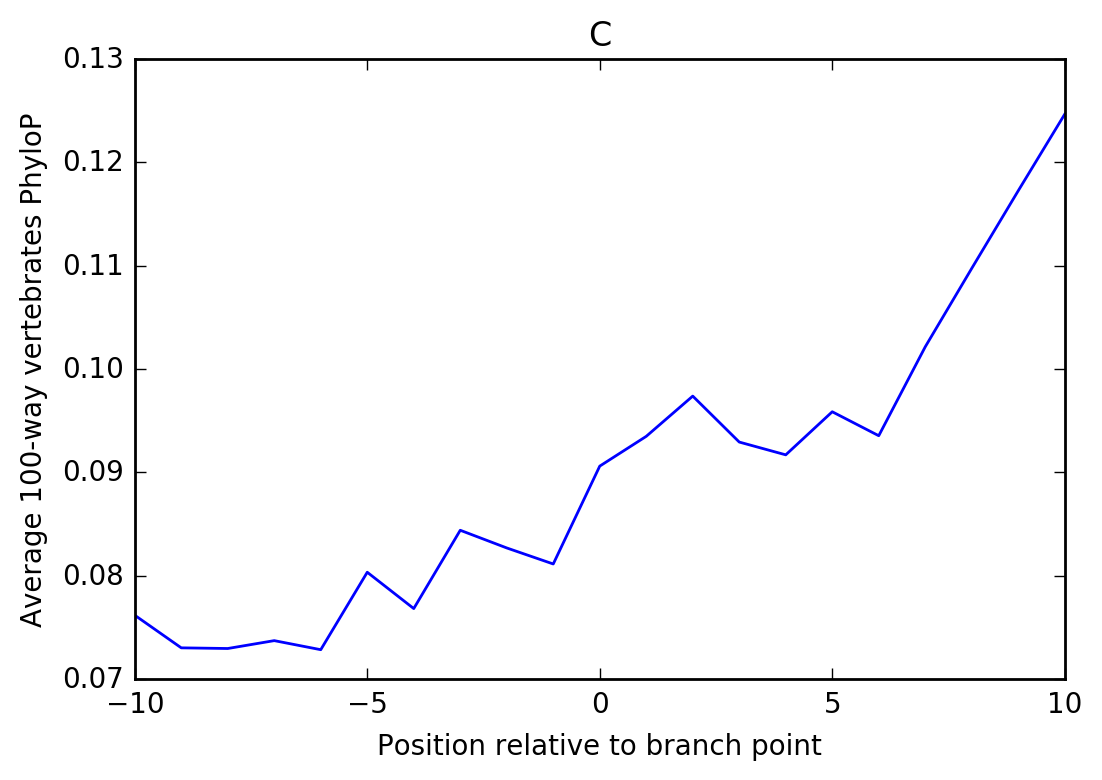

57


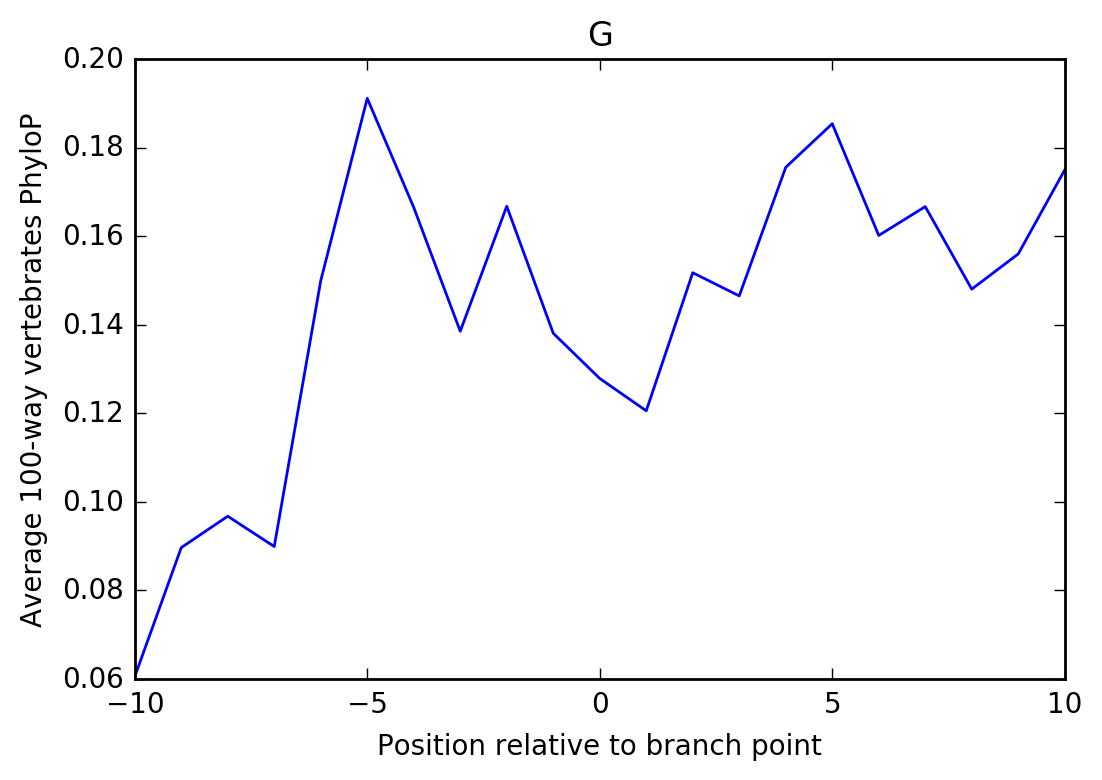

69


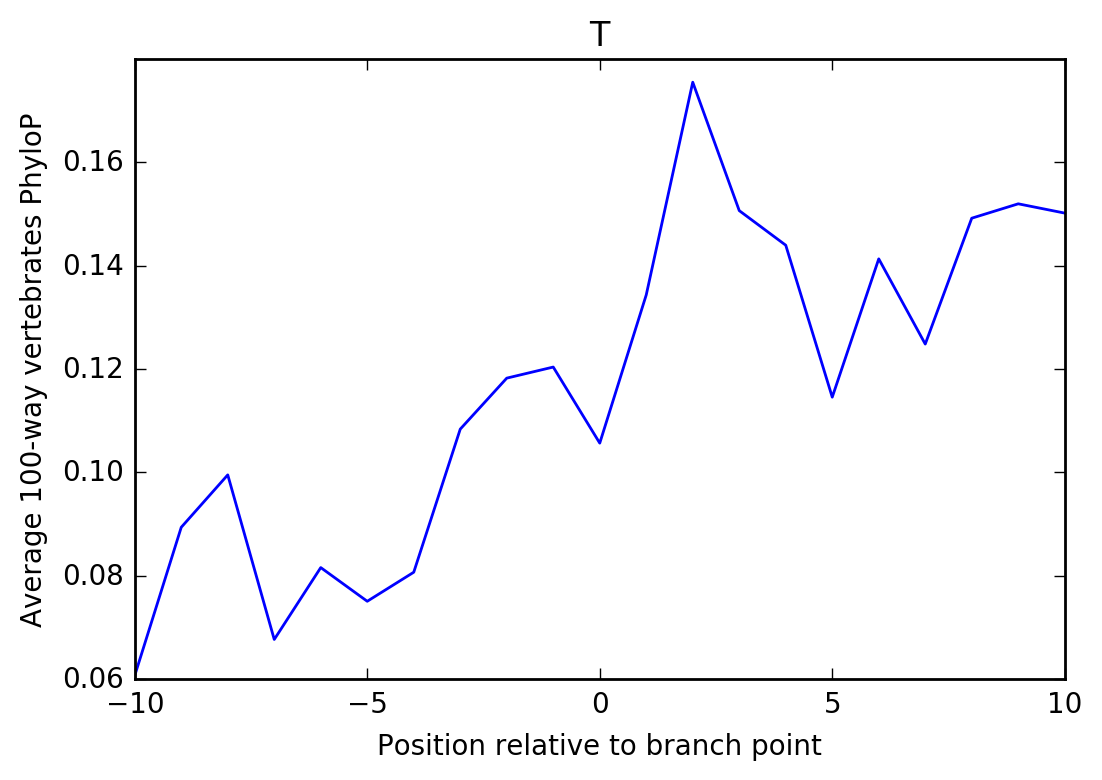

202549


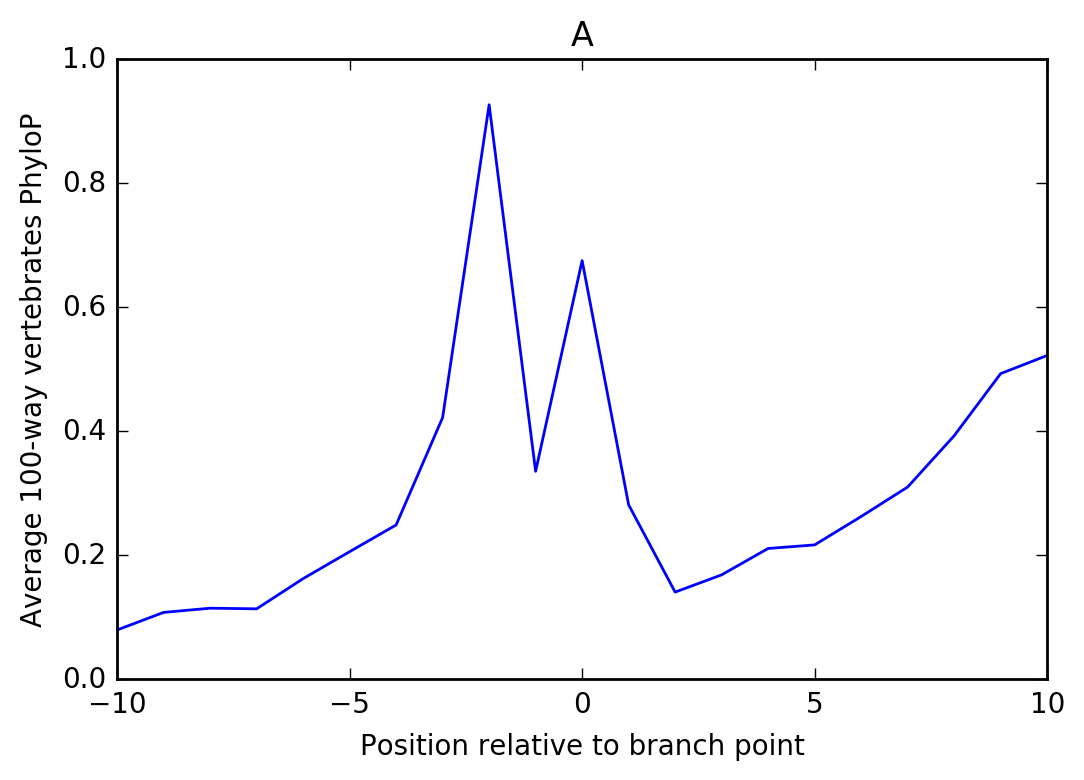

3347


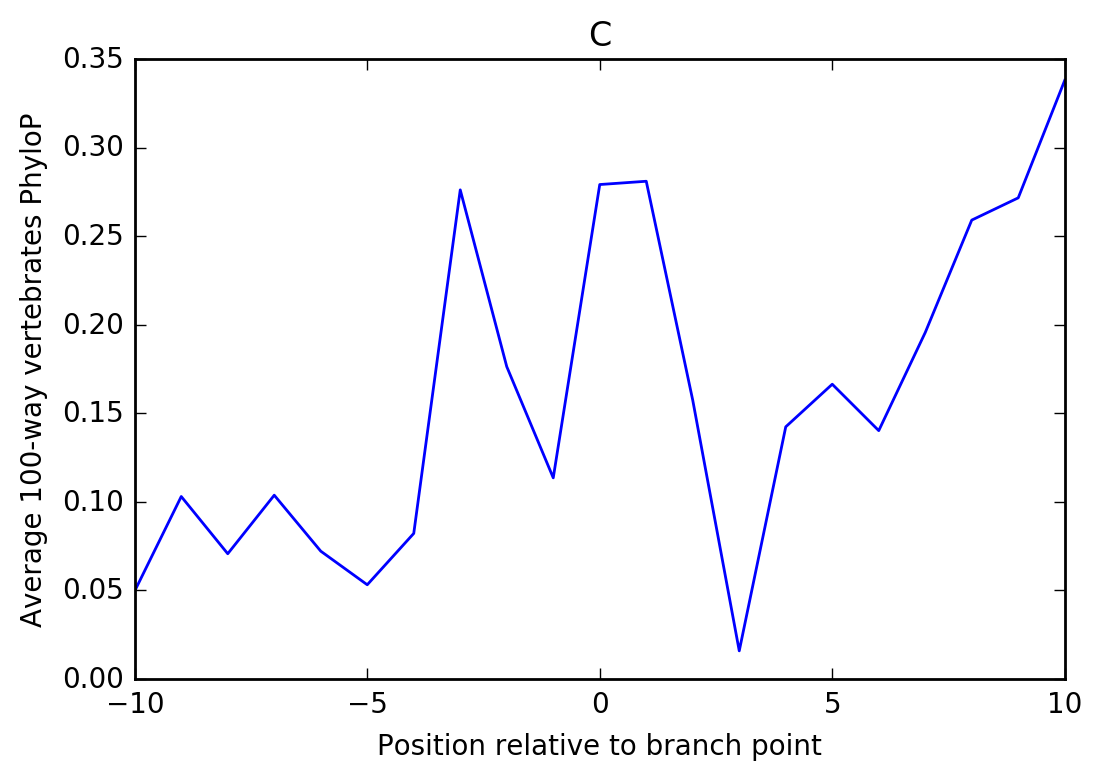

57


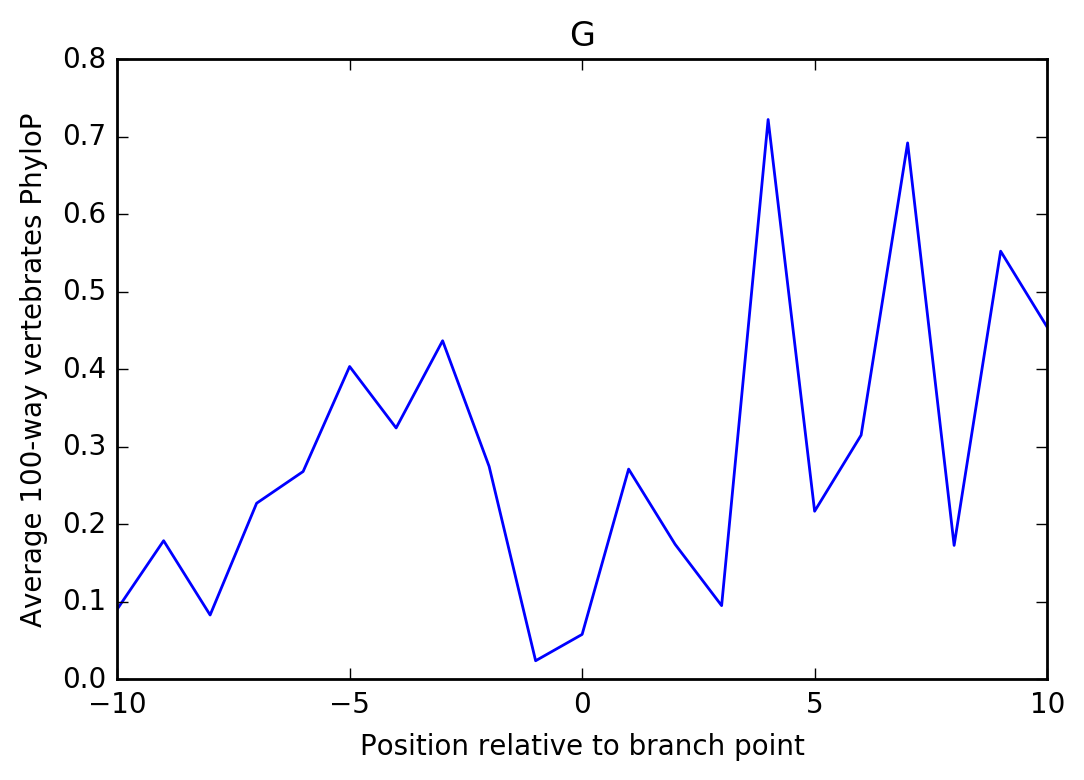

69


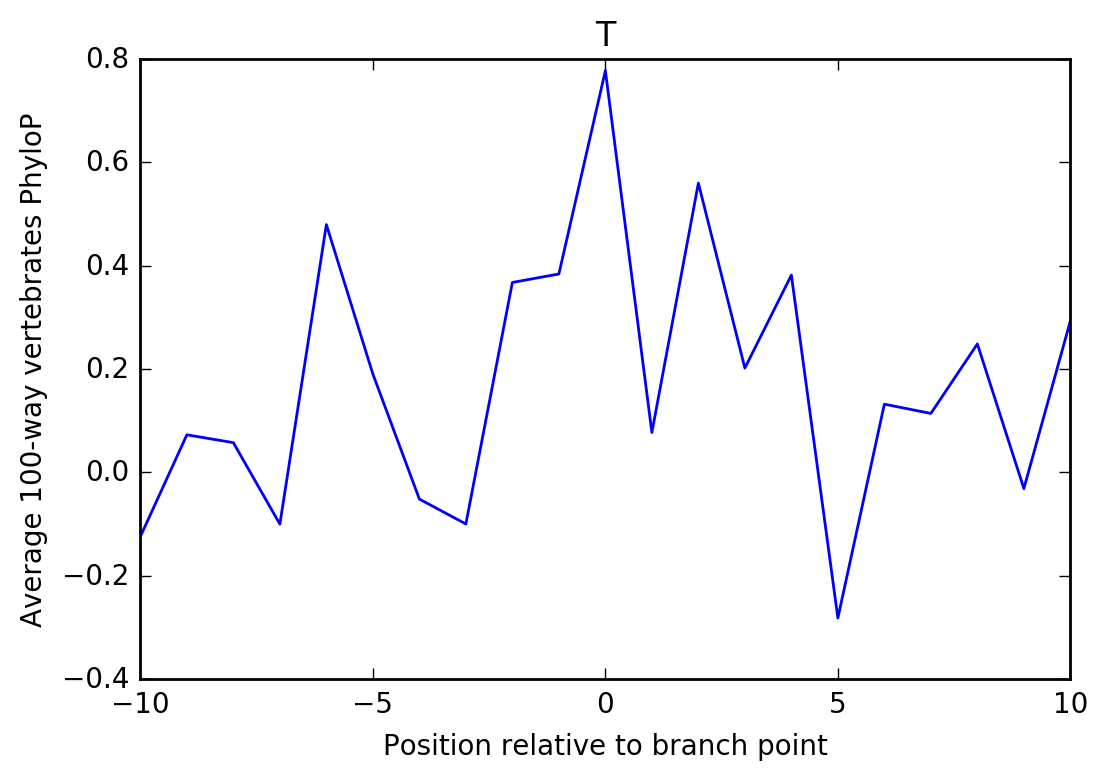

In [12]:
# By BP nucleotide

def cons_novel_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if not seq[bp, base]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_novel_base(X_all, y_all, 4, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_novel_base(X_all, y_all, 5, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()

167172
38850


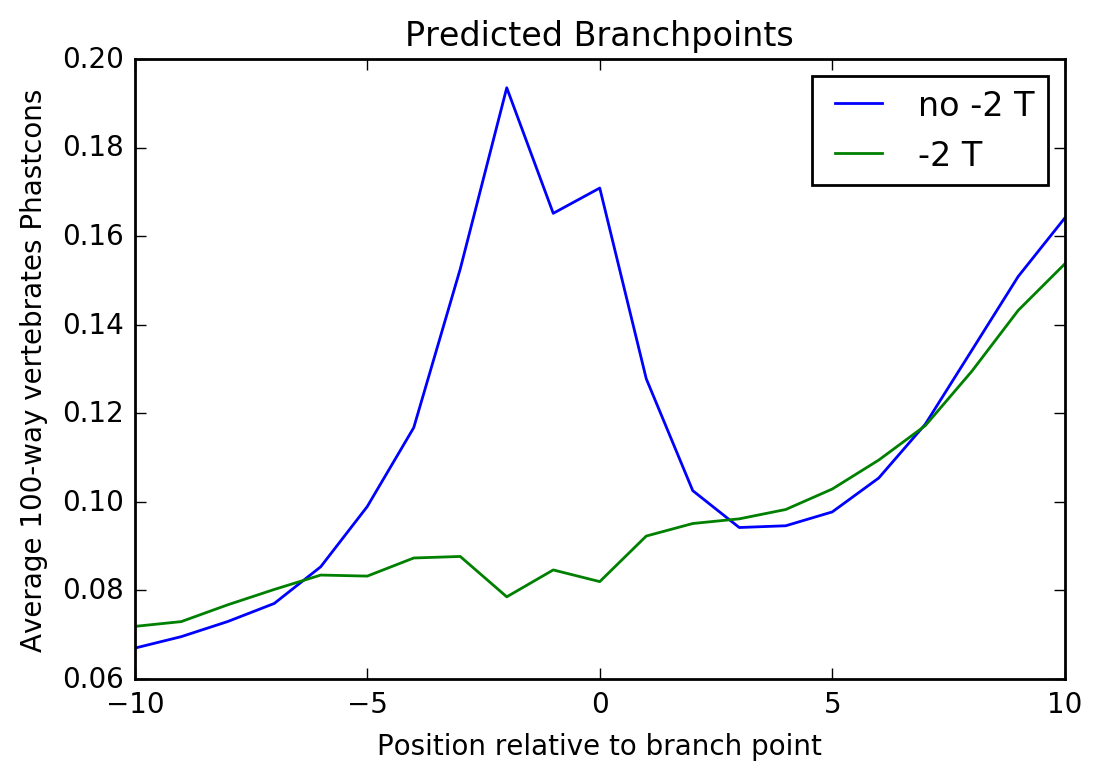

167172
38850


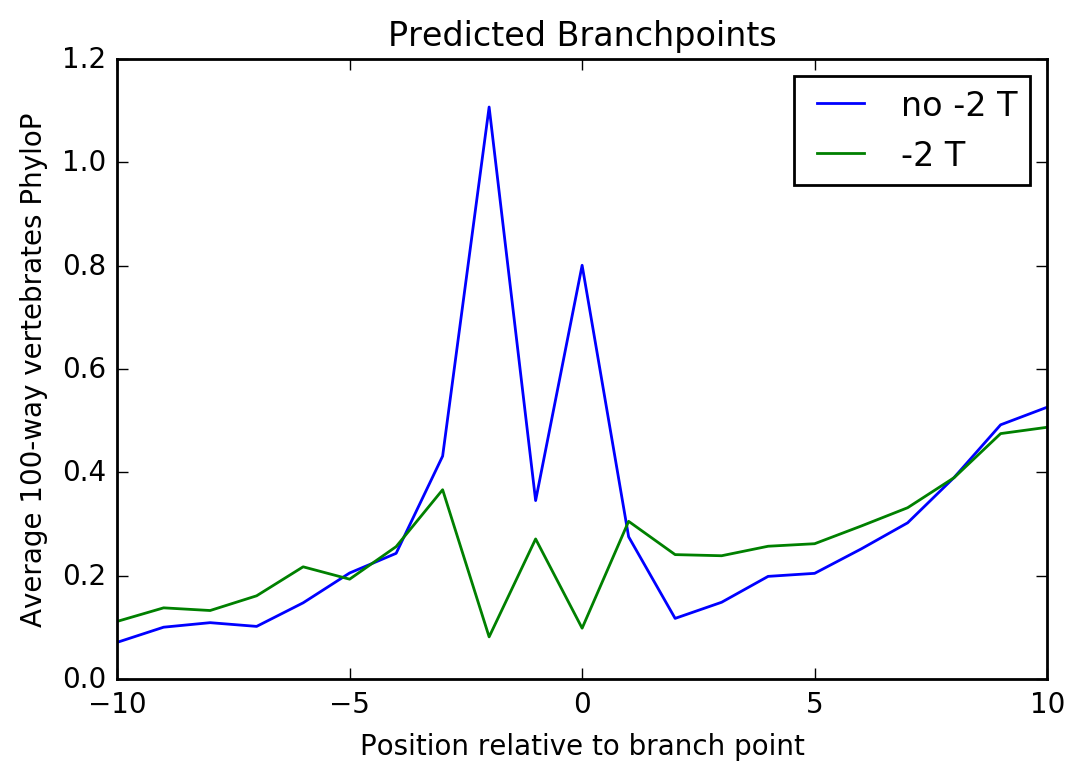

In [13]:
# No -2 T

def cons_novel_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if T==seq[bp-2, 3]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

for t, name in enumerate(['no -2 T','-2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 4, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates Phastcons')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['no -2 T','-2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 5, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

## Dists

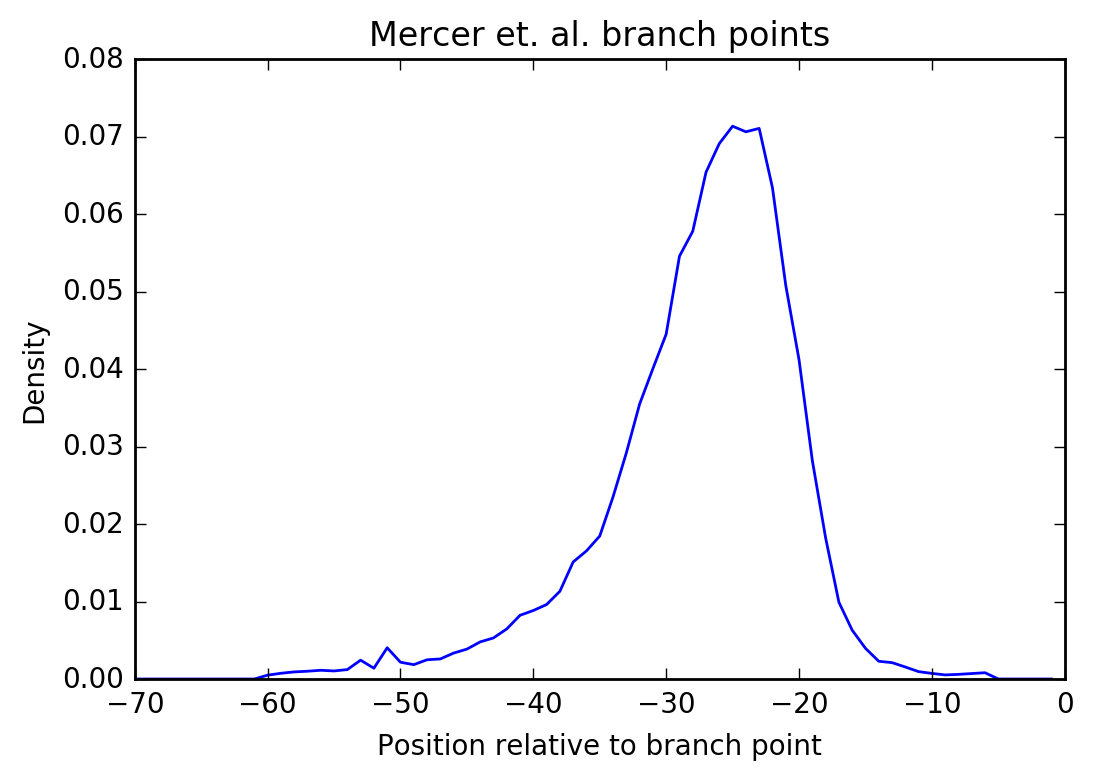

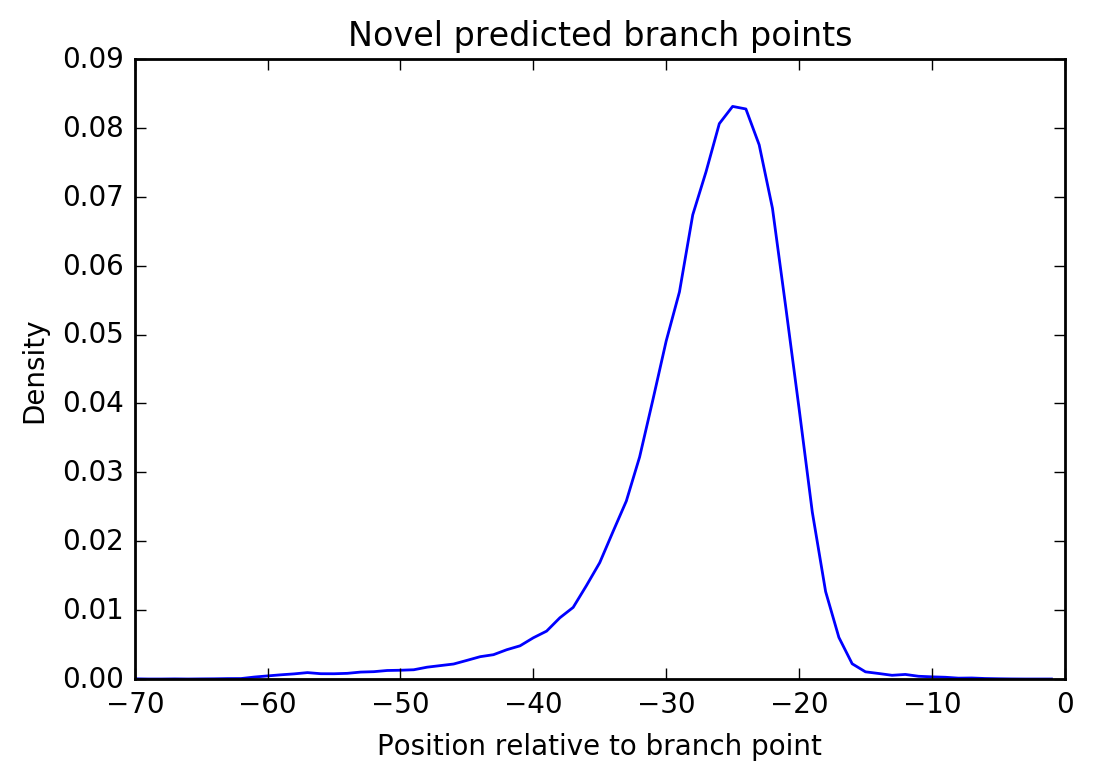

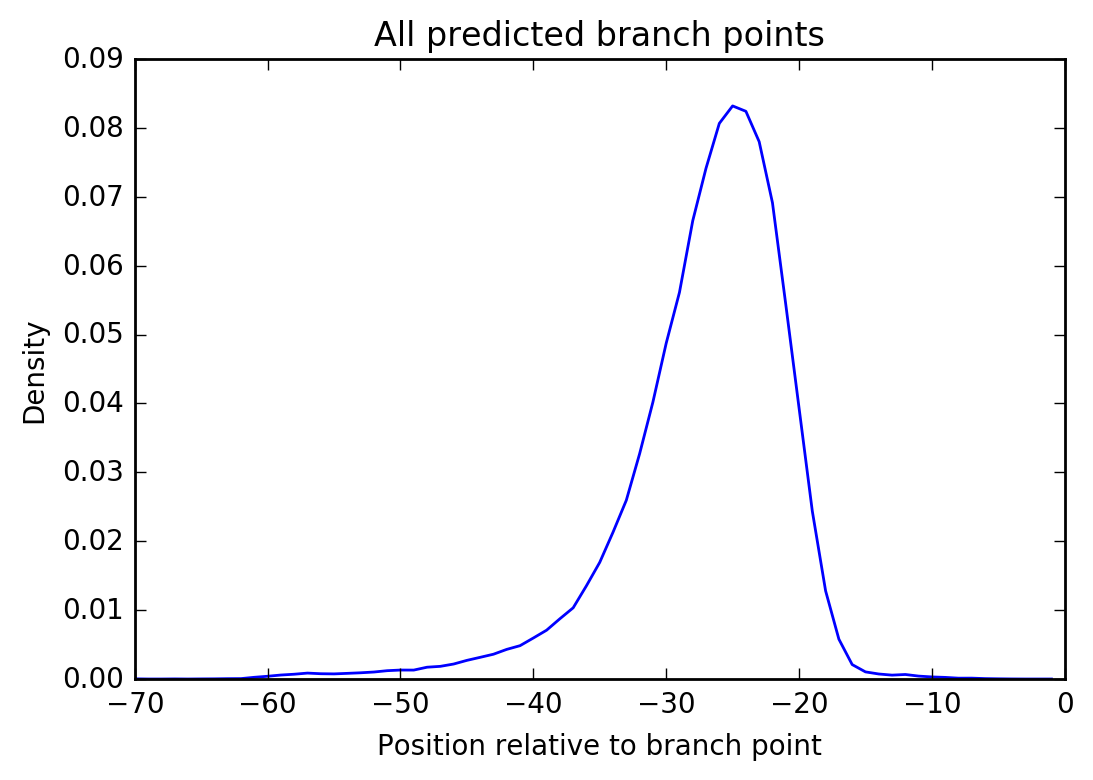

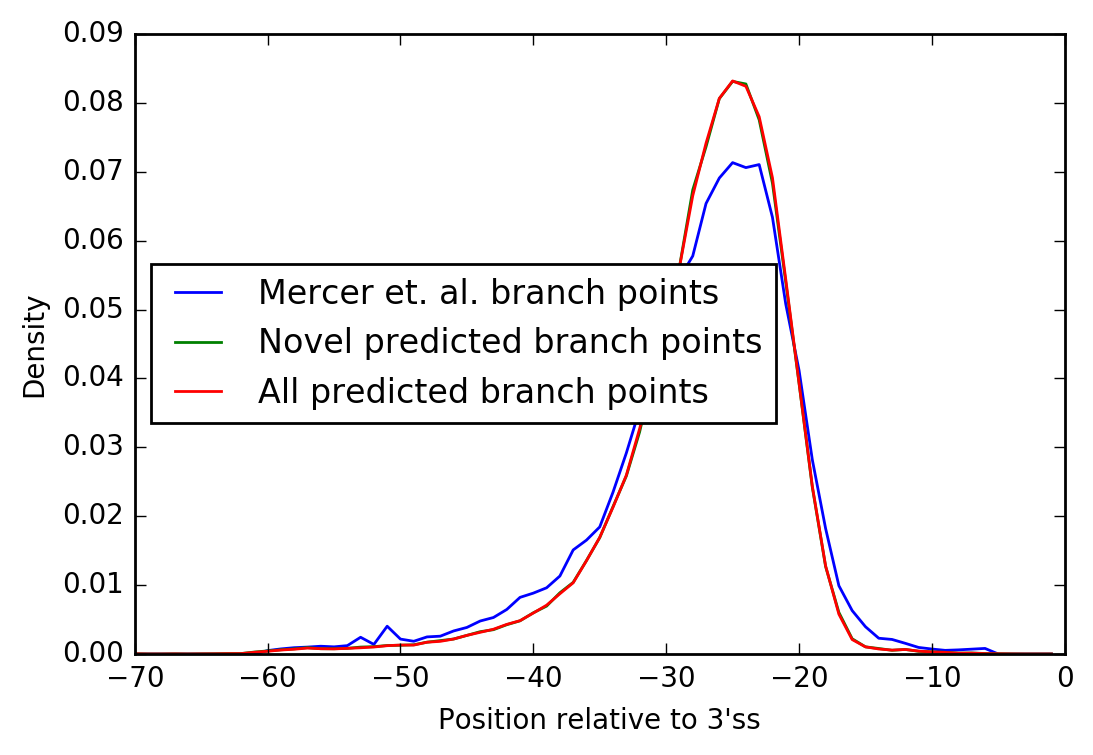

In [14]:
def dist_known(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            counts[bp] += 1
            total += 1
    return counts / total

def dist_novel(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        counts[bp] += 1
        total += 1
    return counts / total

known = dist_known(X_known, y_known, 4)
novel = dist_novel(X_novel, y_novel, 4)
allbp = dist_novel(X_all,   y_all,   4)

dists = [known, novel, allbp]

for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Density')
    plt.show()
    
for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist, label = name)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

## PWM

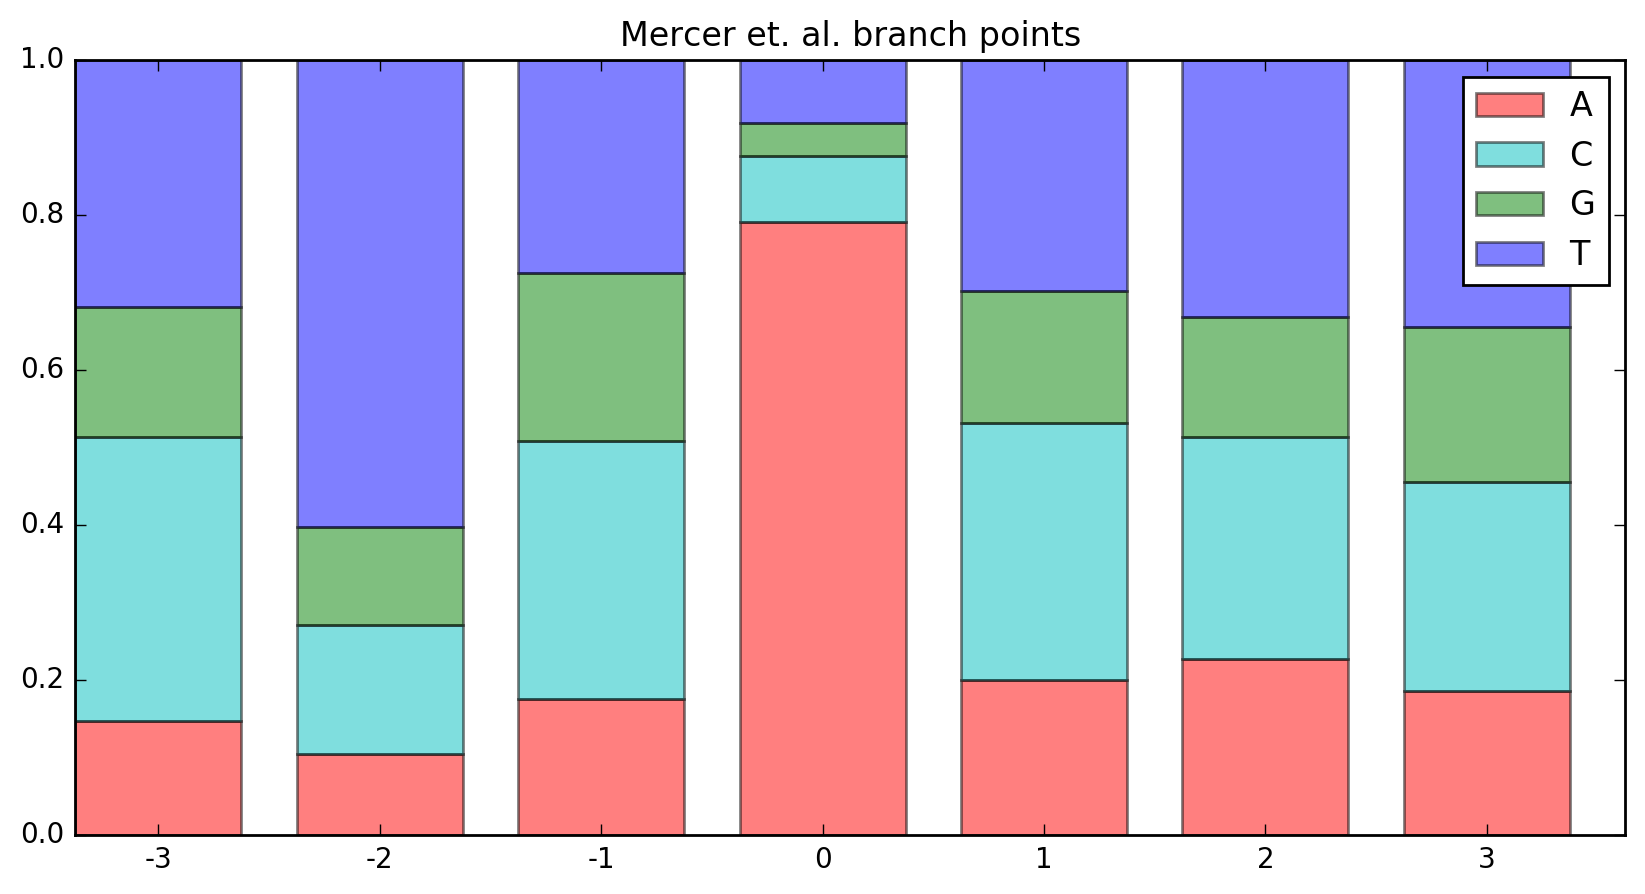

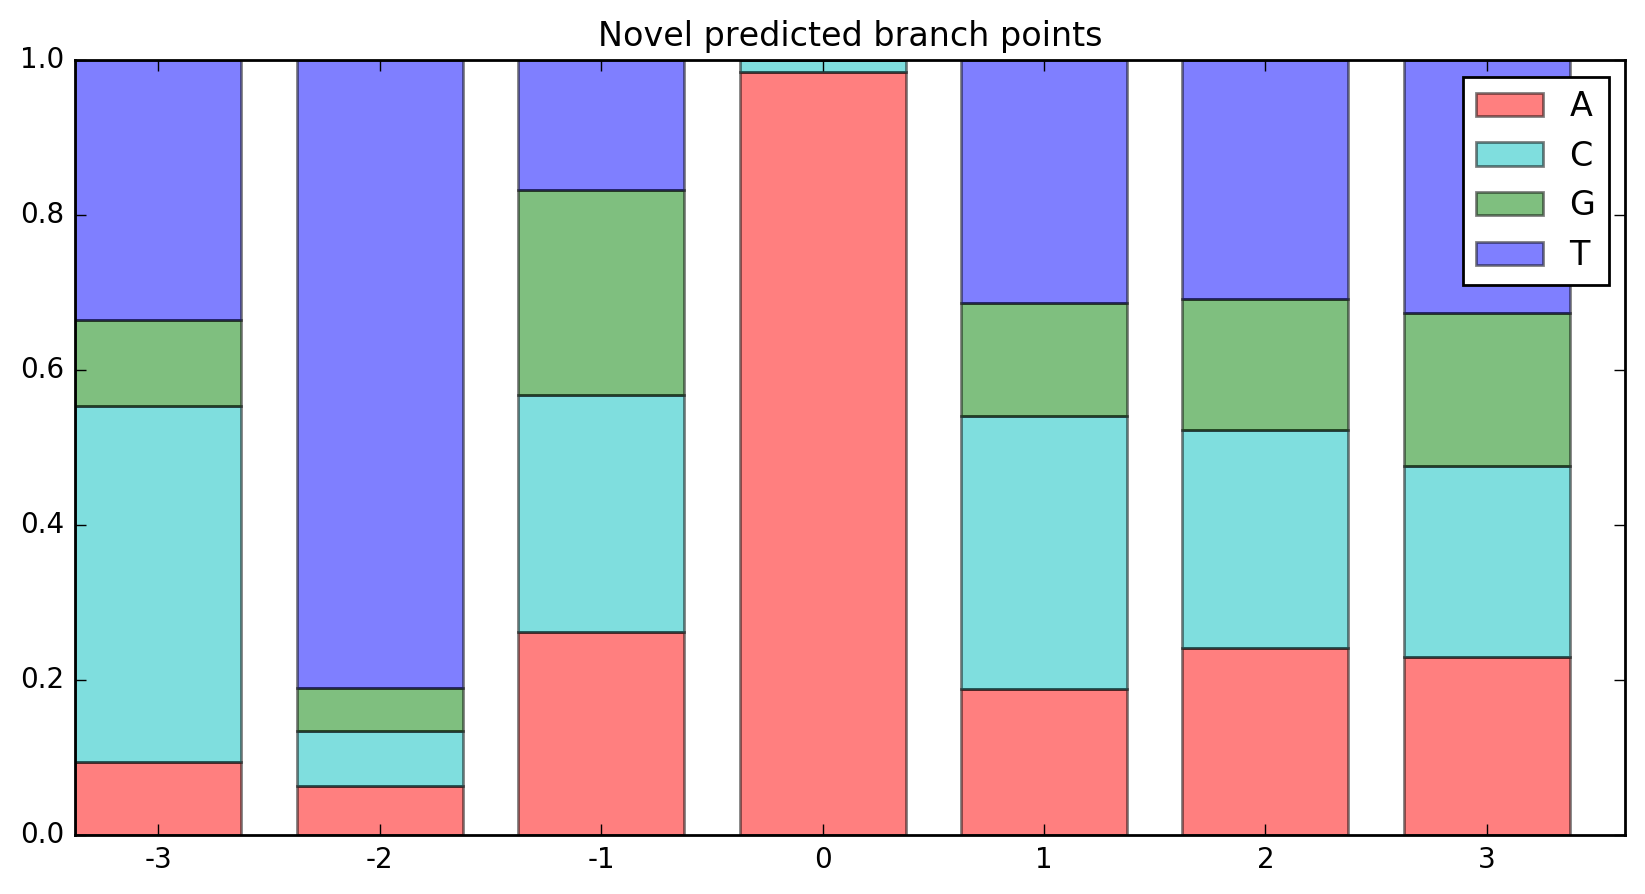

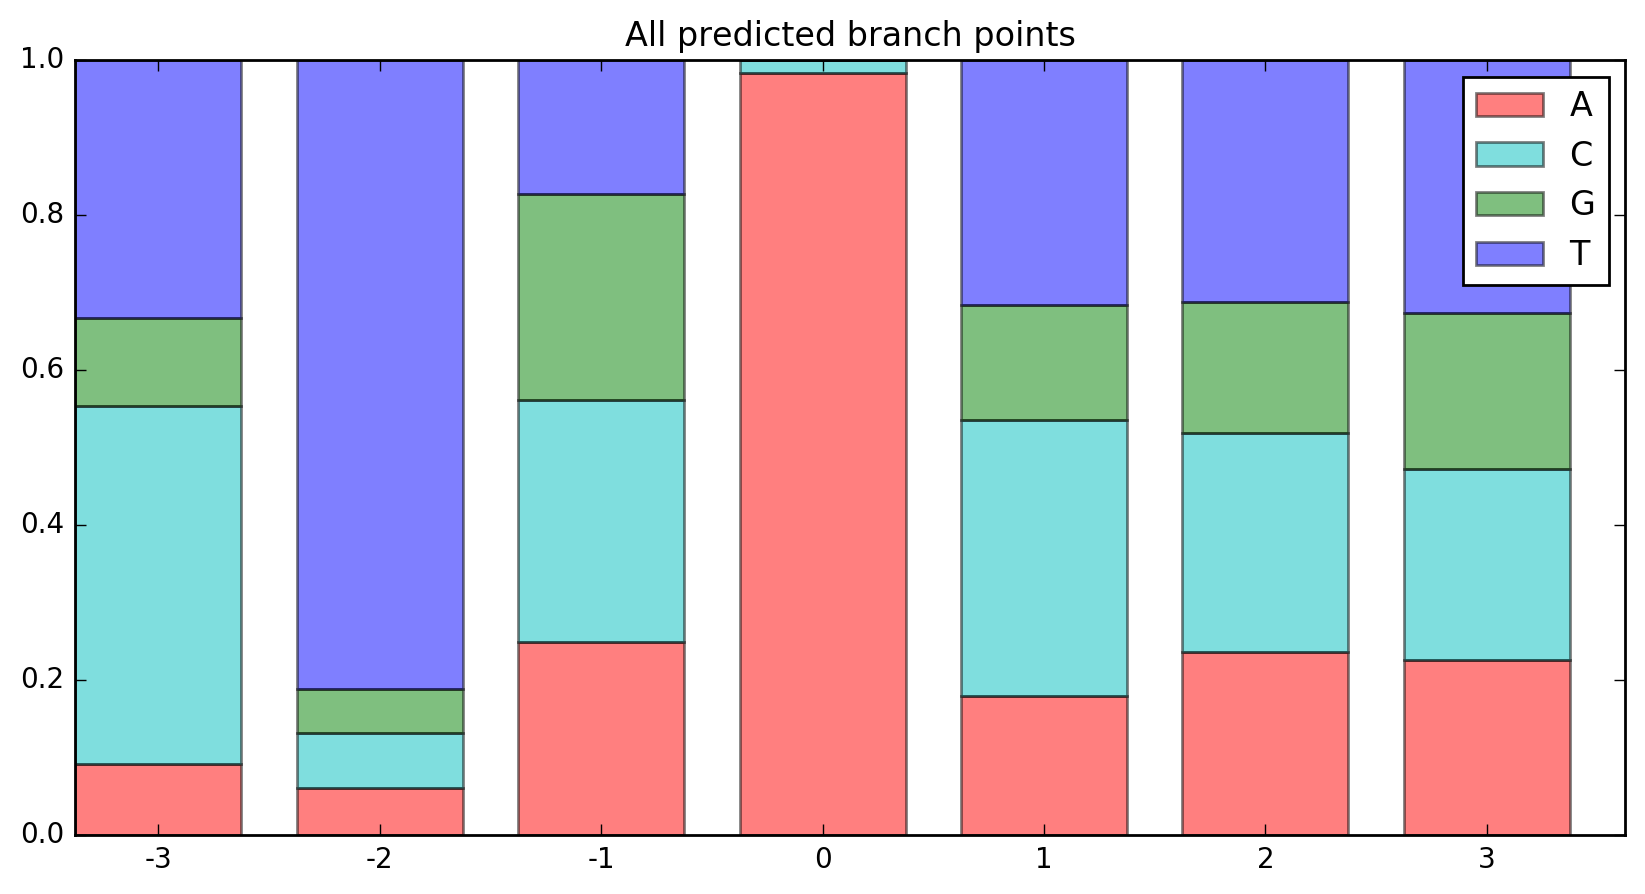

In [15]:
def pwm_logo(pwm, title):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

# Known
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, names[0])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_novel, X_novel):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, names[1])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, names[2])

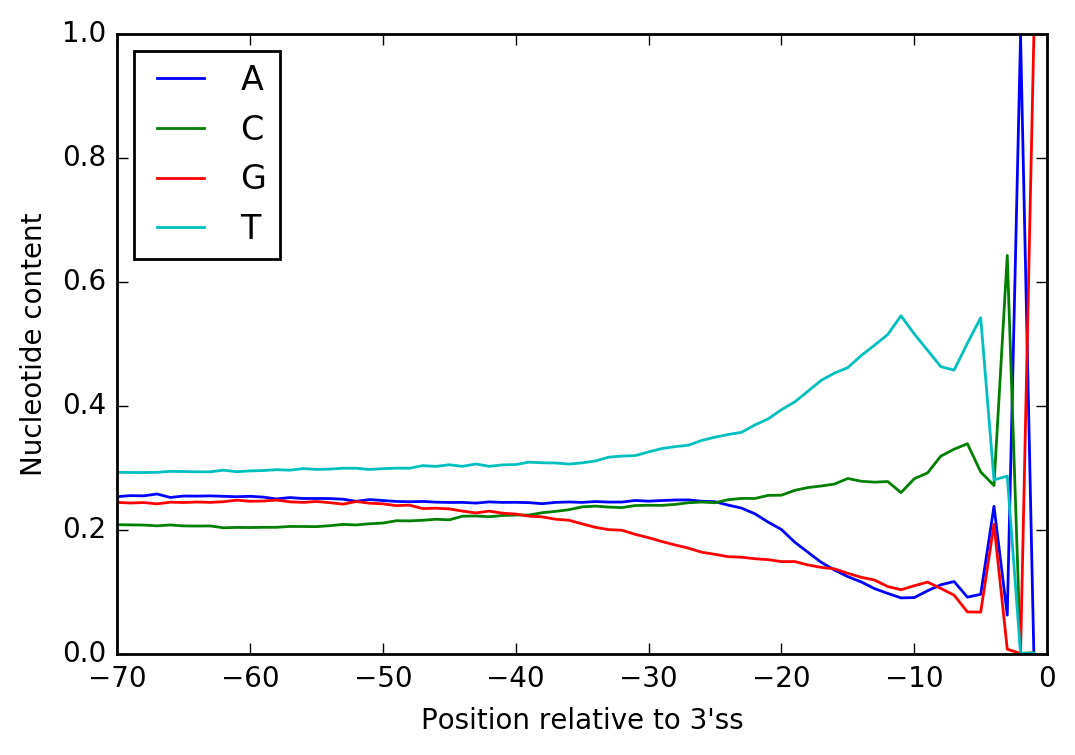

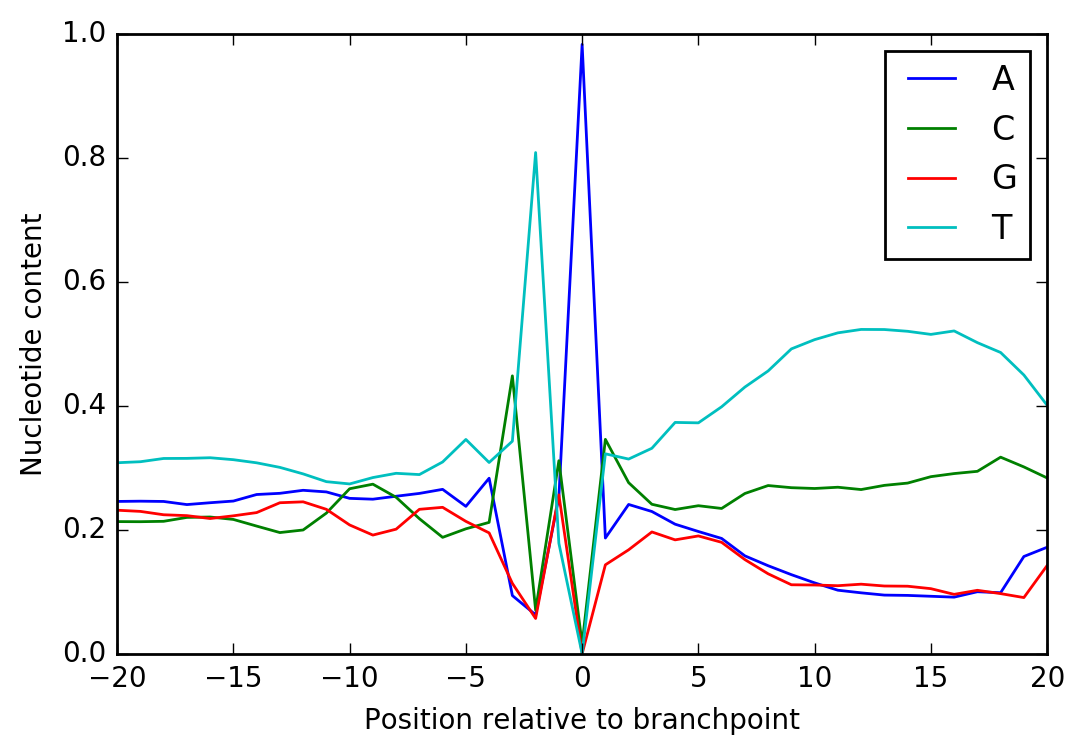

In [16]:
for i, base in enumerate(bases):
    plt.plot(range(-70, 0), X_all[:, :, i].mean(axis = 0), label = base)
plt.legend(loc='best')
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Nucleotide content')
plt.show()

K = 20
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_novel(X_all, y_all, i), label = base)
plt.legend(loc='best')
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Nucleotide content')
plt.show()

In [17]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

from sklearn.utils import shuffle
shuffle_bps = []
for seq, bp in zip(X_all, np.argmax(shuffle(y_all),axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    shuffle_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
shuffle_bps = np.vstack(shuffle_bps)
print shuffle_bps.shape

(160785, 43, 4)
(160785, 43, 4)


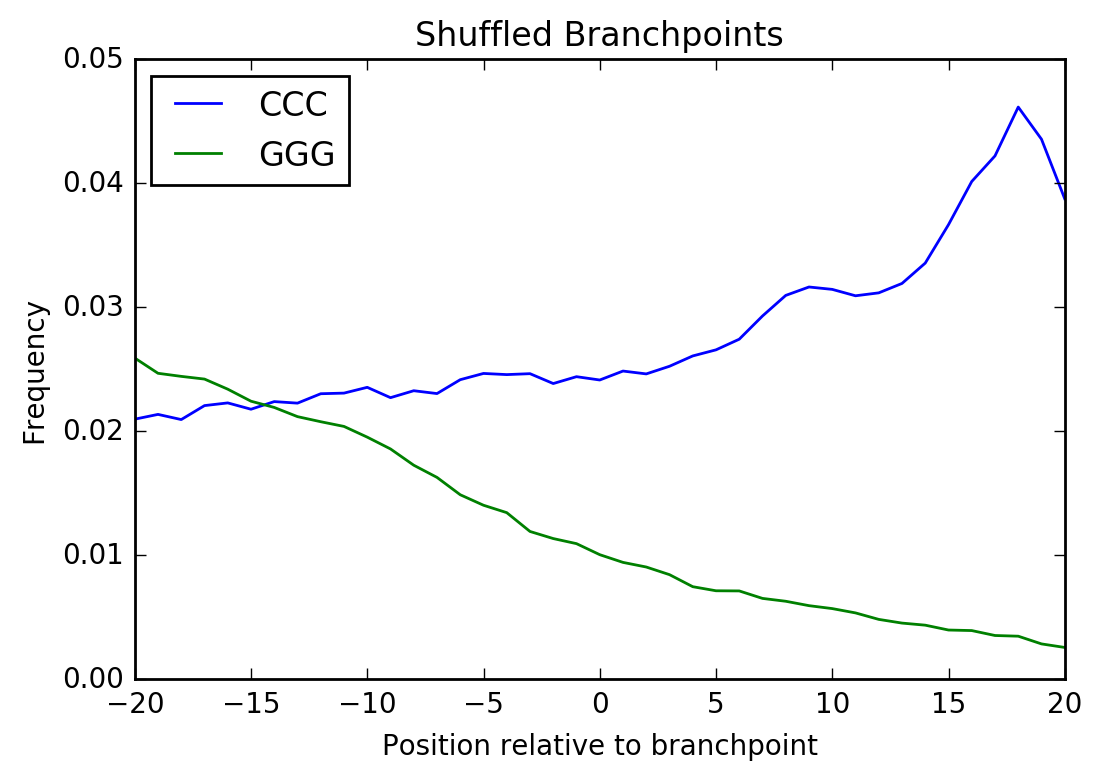

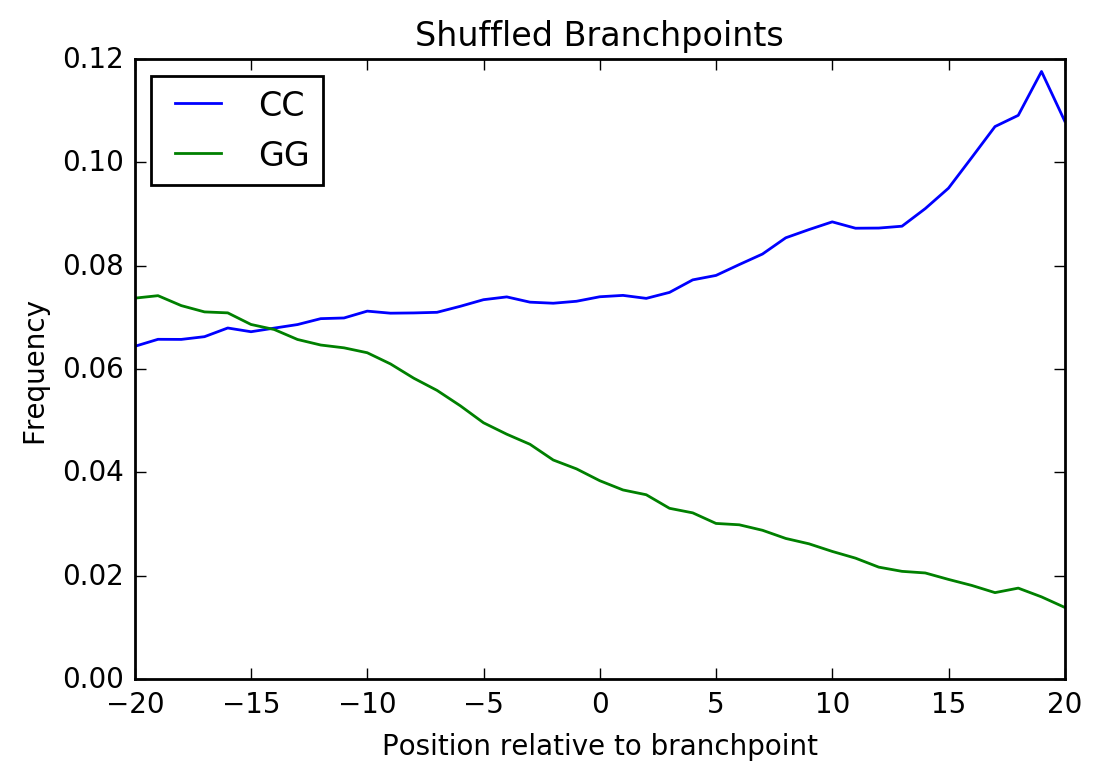

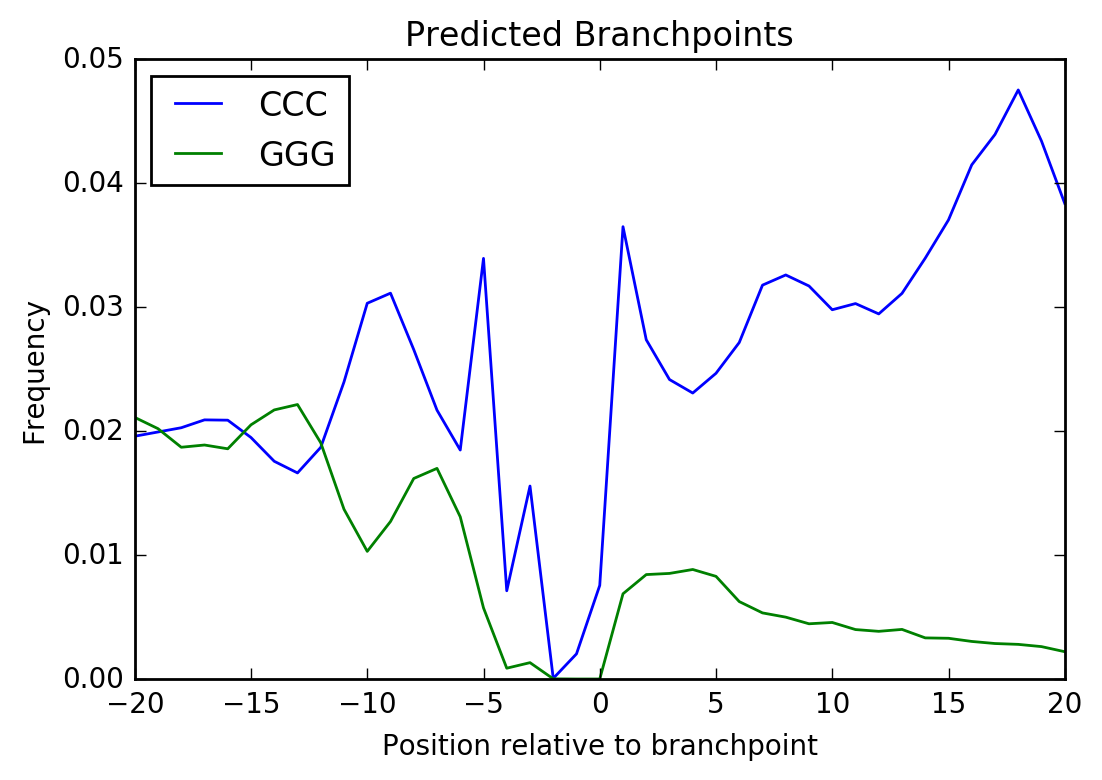

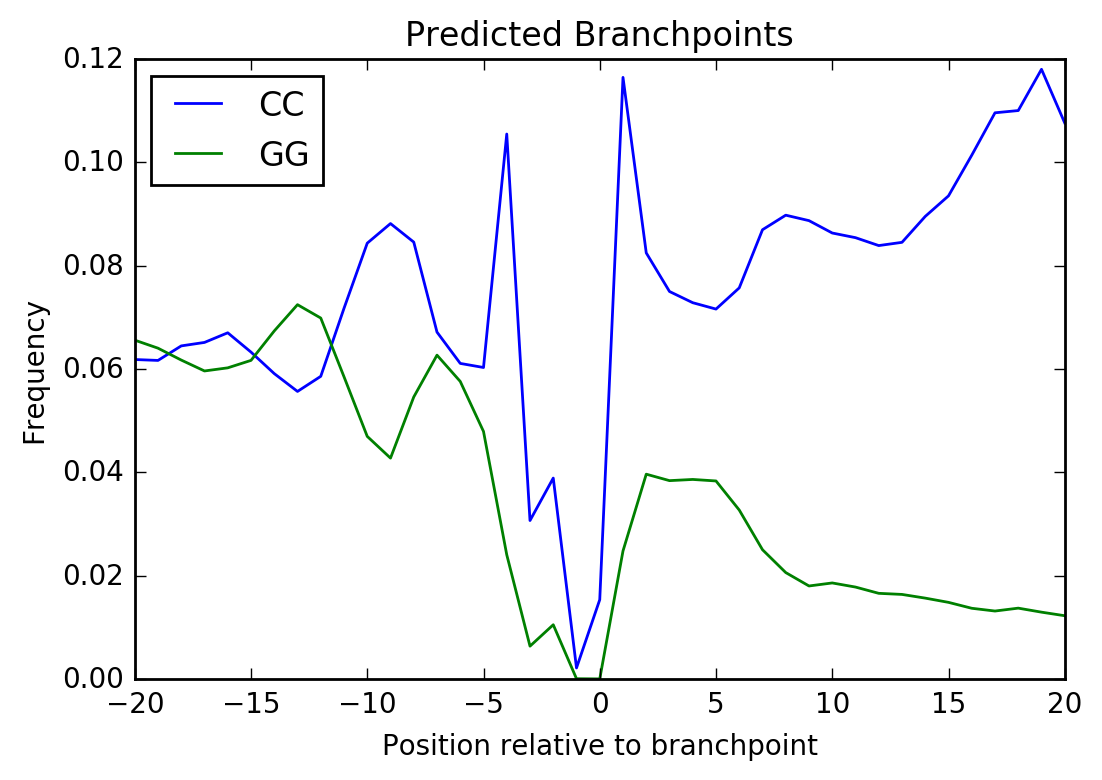

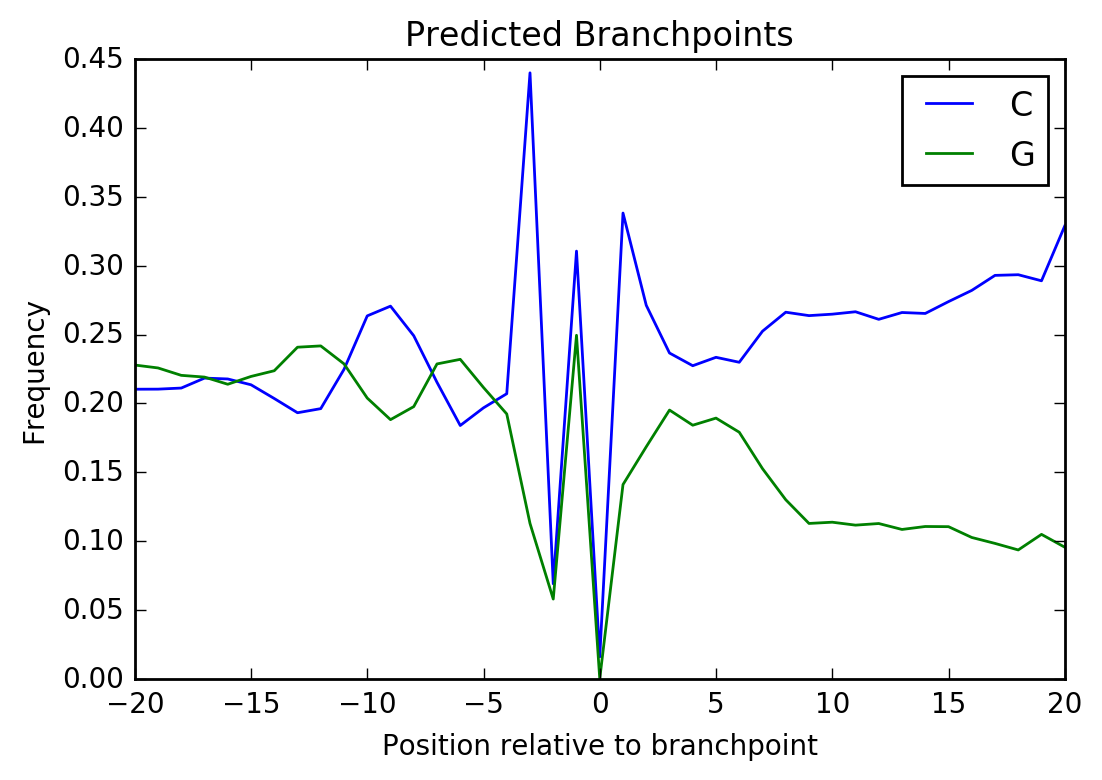

In [18]:
CCC = []
GGG = []
for i in range(41):
    CCC += [sum(shuffle_bps[:, i, 1]*shuffle_bps[:, i+1, 1]*shuffle_bps[:, i+2, 1])]
    GGG += [sum(shuffle_bps[:, i, 2]*shuffle_bps[:, i+1, 2]*shuffle_bps[:, i+2, 2])]
plt.plot(range(-20, 21),
         np.array(CCC) / float(bps.shape[0]),
         label = 'CCC')
plt.plot(range(-20, 21),
         np.array(GGG) / float(bps.shape[0]),
         label = 'GGG')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.legend(loc = 'best')
plt.title('Shuffled Branchpoints')
plt.show()
CC = []
GG = []
for i in range(41):
    CC += [sum(shuffle_bps[:, i, 1]*shuffle_bps[:, i+1, 1])]
    GG += [sum(shuffle_bps[:, i, 2]*shuffle_bps[:, i+1, 2])]
plt.plot(range(-20, 21),
         np.array(CC) / float(shuffle_bps.shape[0]),
         label = 'CC')
plt.plot(range(-20, 21),
         np.array(GG) / float(shuffle_bps.shape[0]),
         label = 'GG')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Shuffled Branchpoints')
plt.show()

CCC = []
GGG = []
for i in range(41):
    CCC += [sum(bps[:, i, 1]*bps[:, i+1, 1]*bps[:, i+2, 1])]
    GGG += [sum(bps[:, i, 2]*bps[:, i+1, 2]*bps[:, i+2, 2])]
plt.plot(range(-20, 21),
         np.array(CCC) / float(bps.shape[0]),
         label = 'CCC')
plt.plot(range(-20, 21),
         np.array(GGG) / float(bps.shape[0]),
         label = 'GGG')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.legend(loc = 'best')
plt.title('Predicted Branchpoints')
plt.show()
CC = []
GG = []
for i in range(41):
    CC += [sum(bps[:, i, 1]*bps[:, i+1, 1])]
    GG += [sum(bps[:, i, 2]*bps[:, i+1, 2])]
plt.plot(range(-20, 21),
         np.array(CC) / float(bps.shape[0]),
         label = 'CC')
plt.plot(range(-20, 21),
         np.array(GG) / float(bps.shape[0]),
         label = 'GG')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Predicted Branchpoints')
plt.show()

C = []
G = []
for i in range(41):
    C += [sum(bps[:, i, 1])]
    G += [sum(bps[:, i, 2])]
plt.plot(range(-20, 21),
         np.array(C) / float(bps.shape[0]),
         label = 'C')
plt.plot(range(-20, 21),
         np.array(G) / float(bps.shape[0]),
         label = 'G')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Predicted Branchpoints')
plt.show()

44922


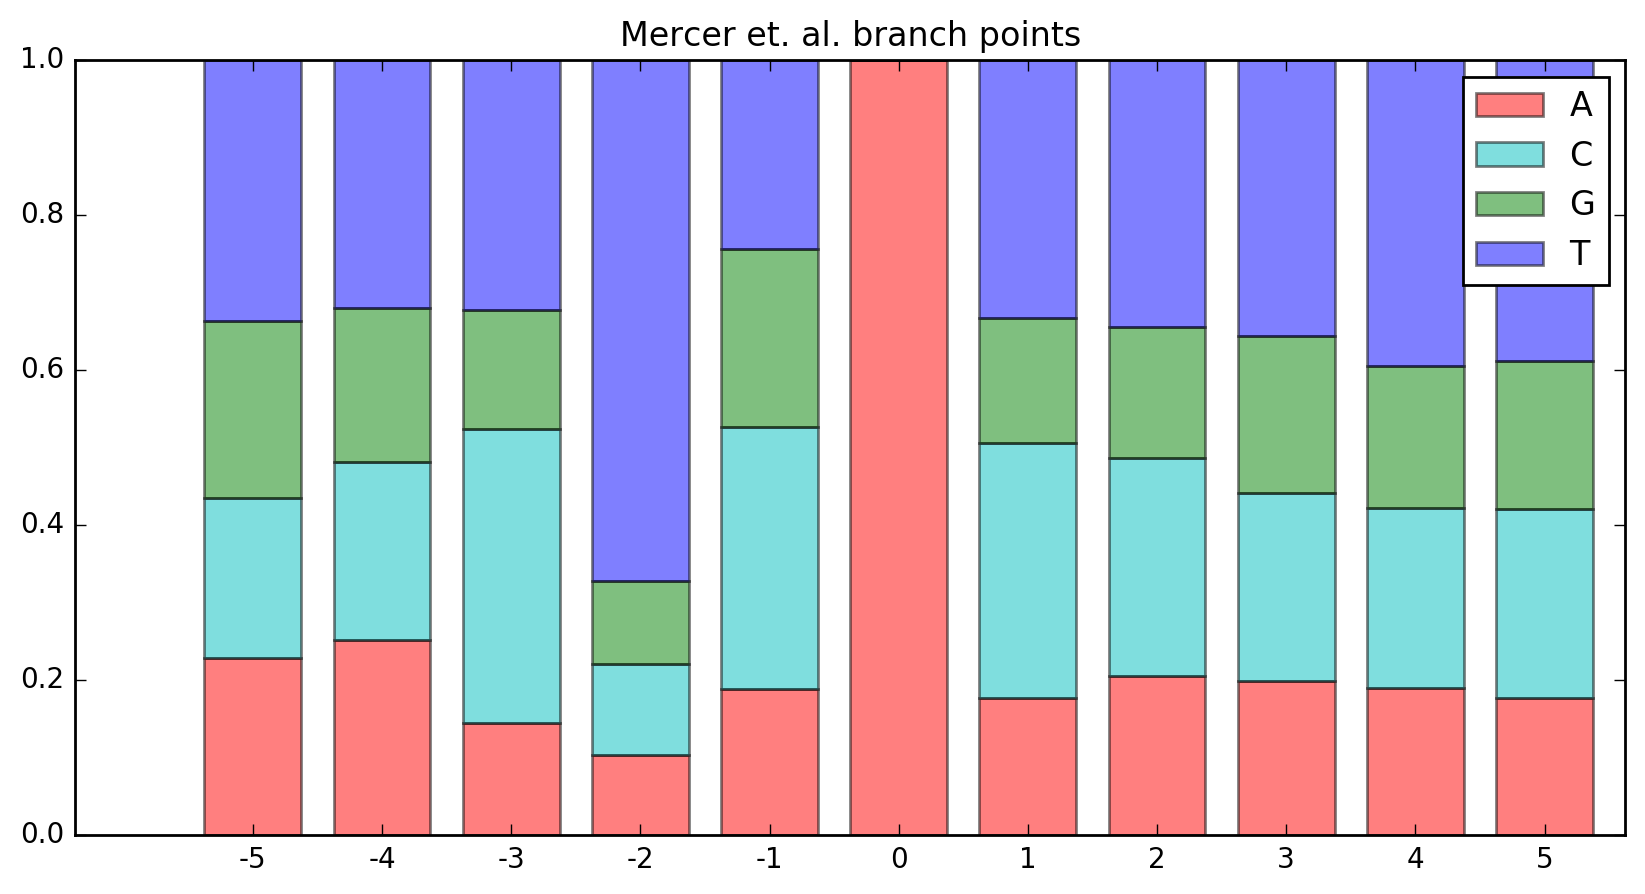

4840


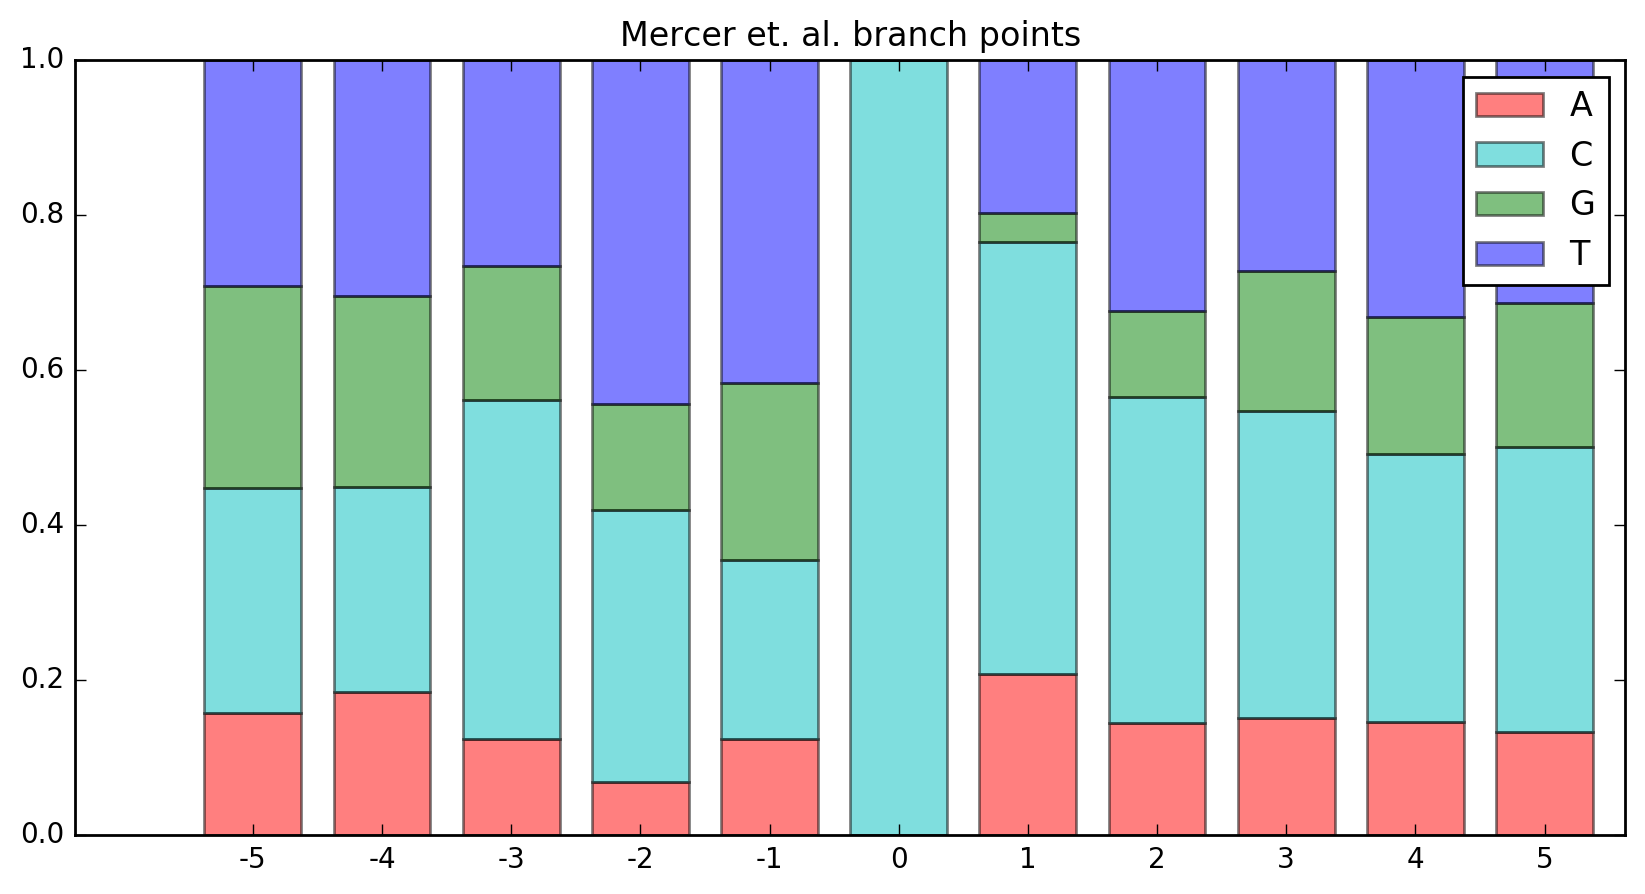

2439


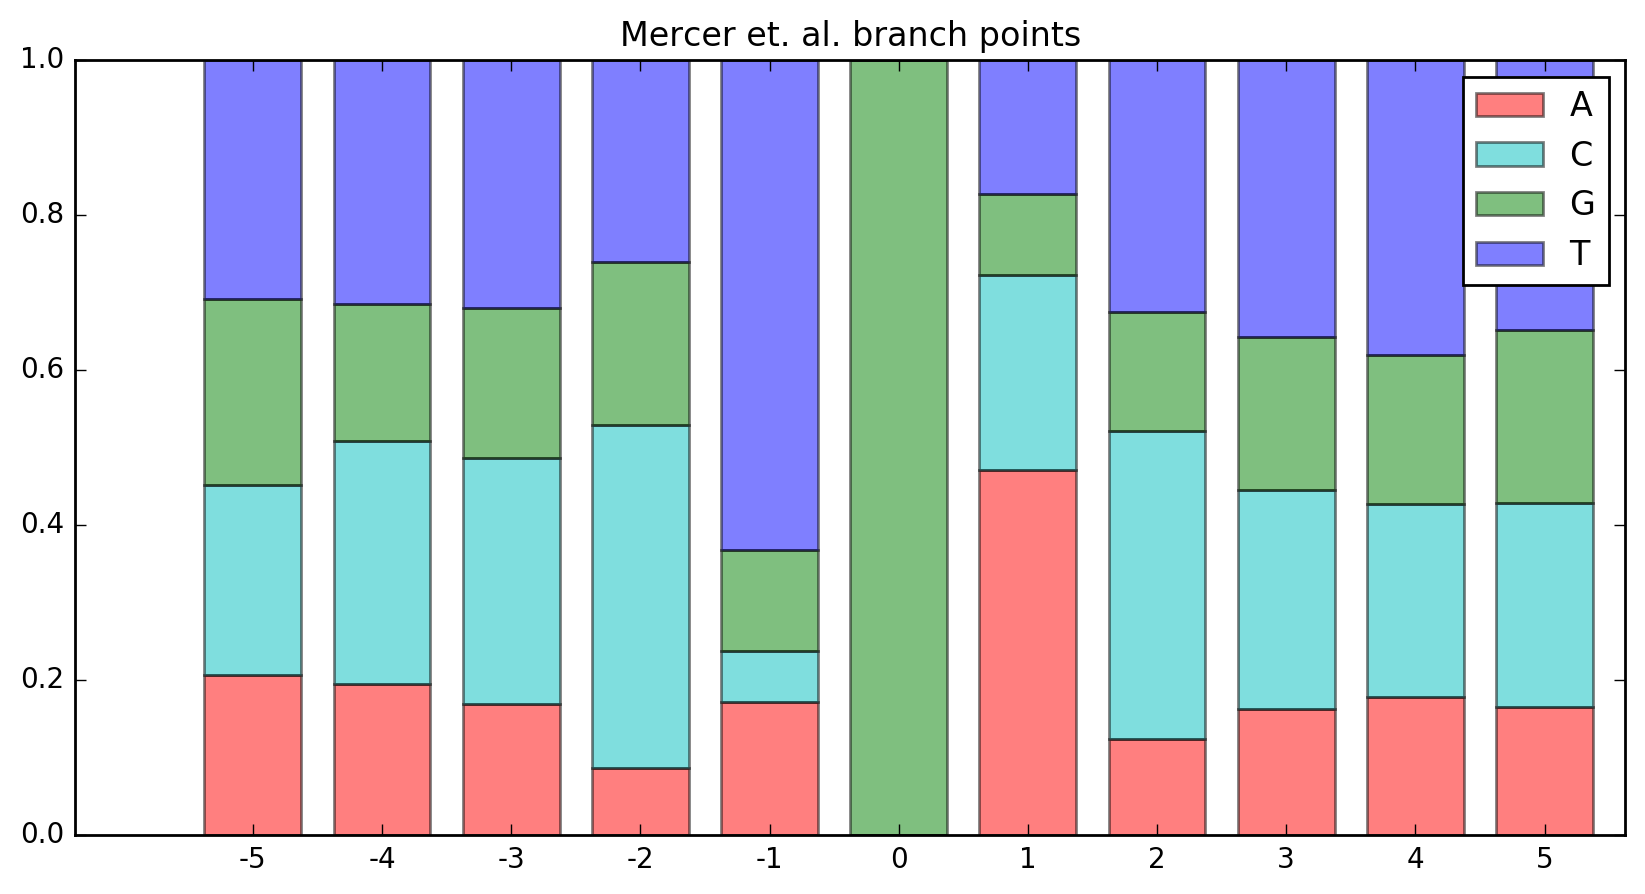

4607


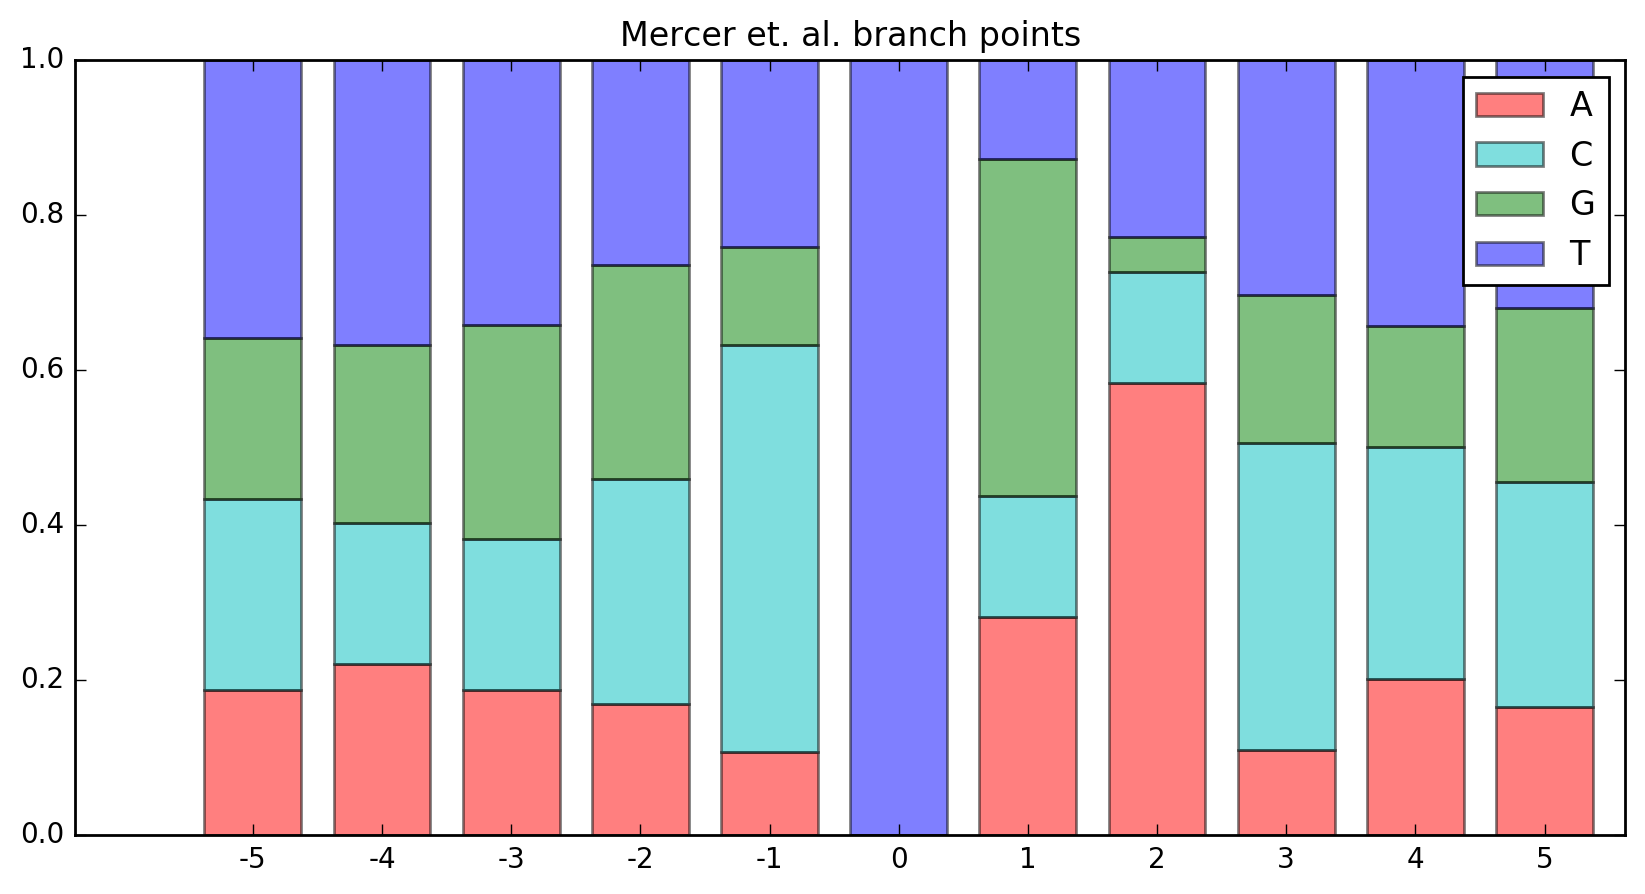

In [19]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_known, X_known):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, i]: continue
            counts += seq[bp-K: bp+K+1, :4]
            total += 1
    print total
    pwm_logo(counts / total, names[0])

202799


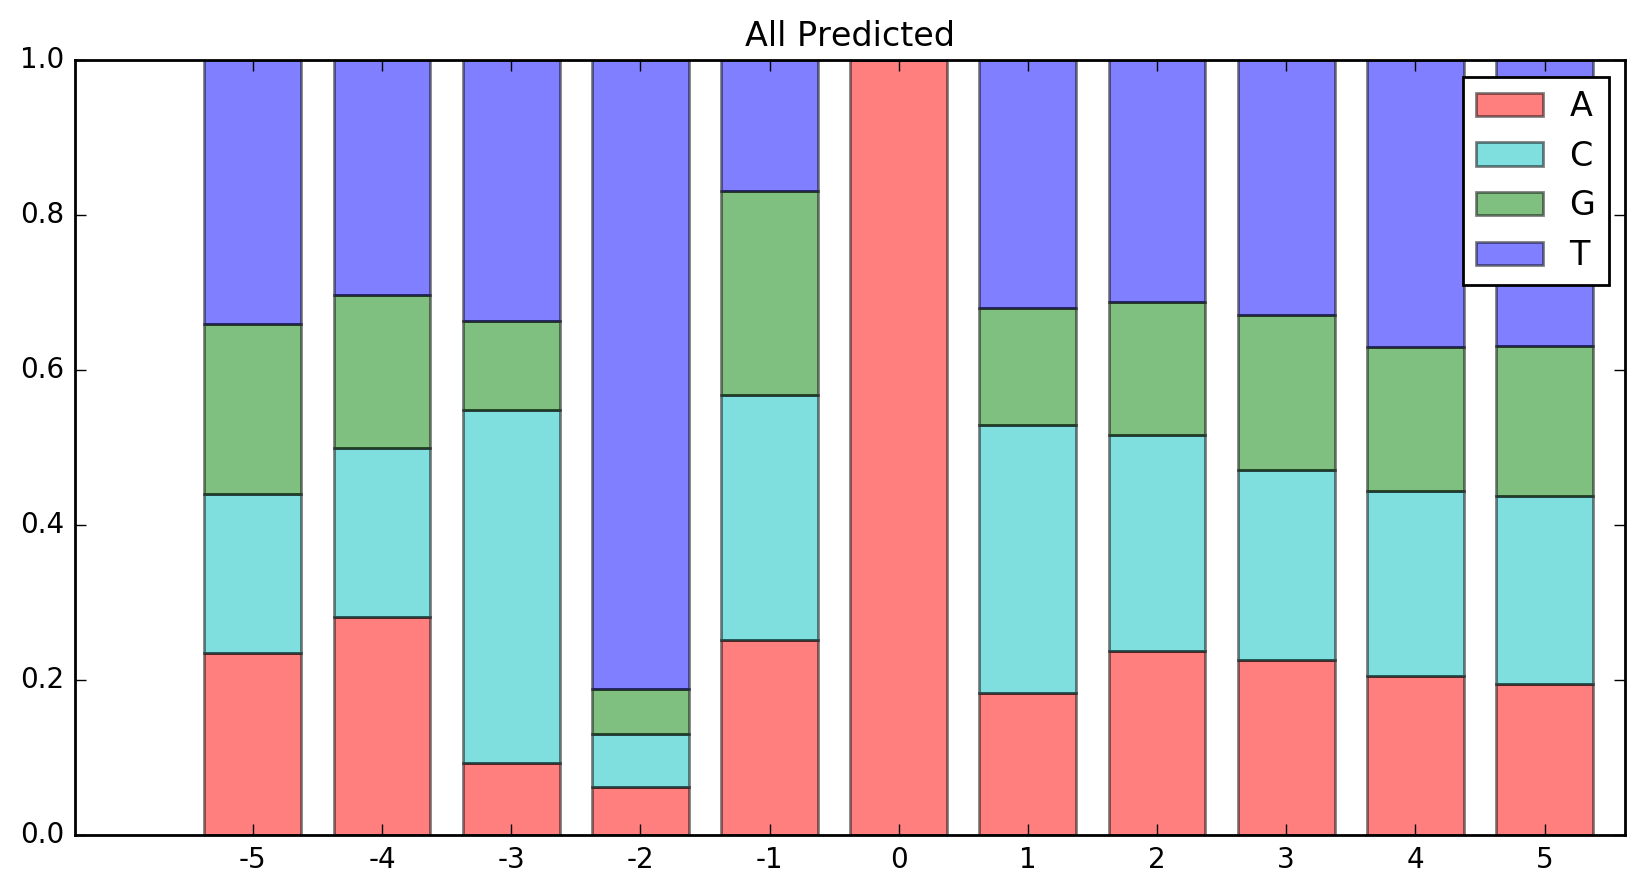

3351


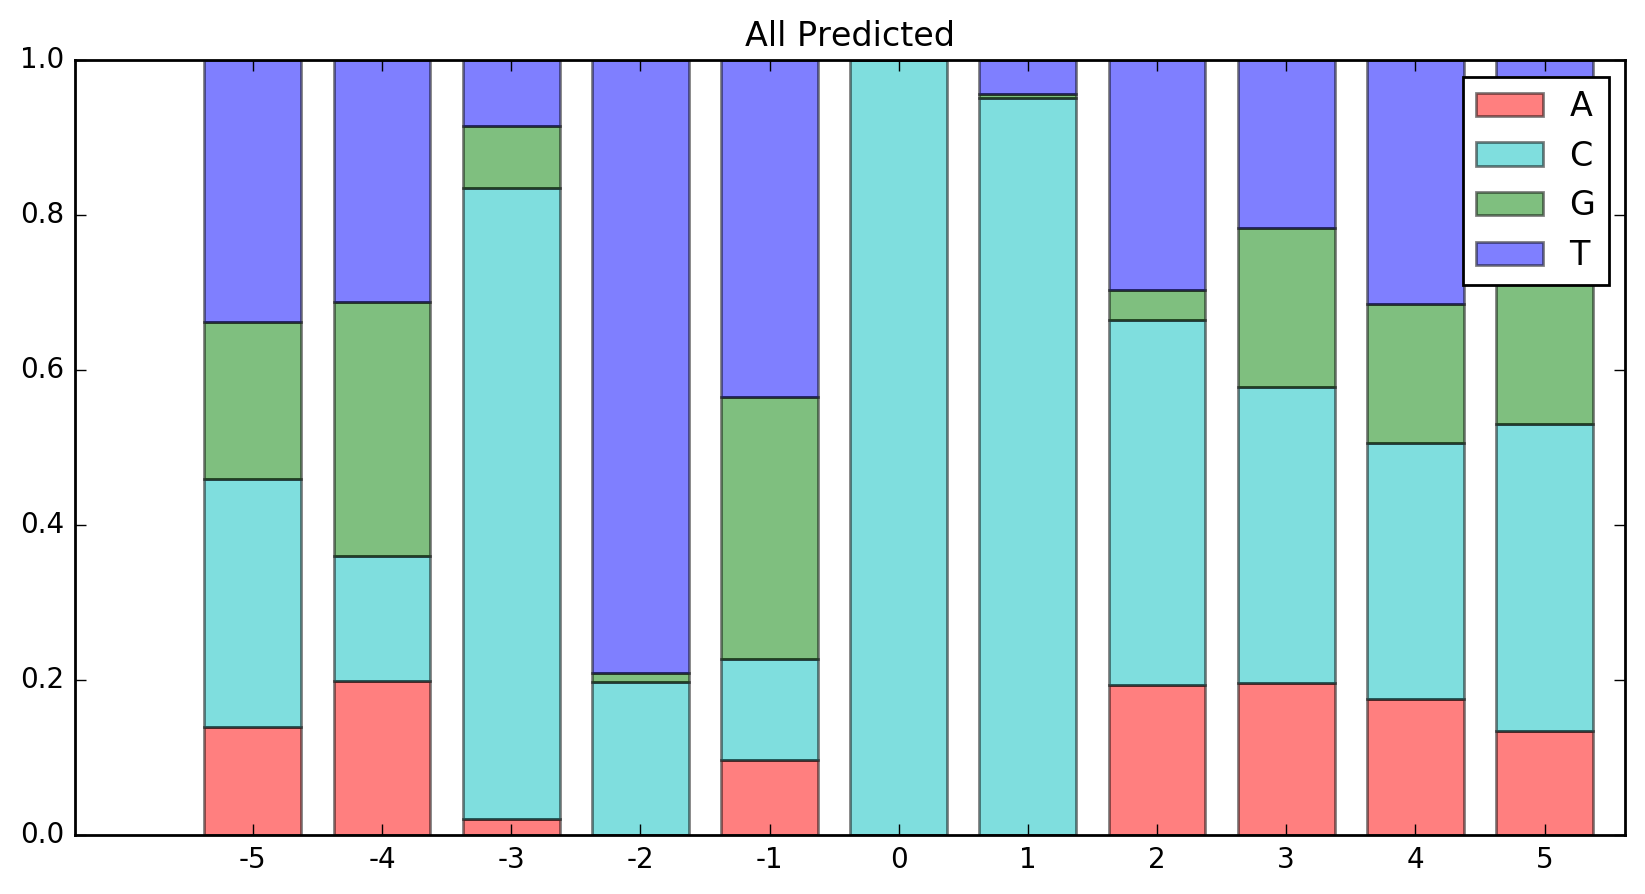

57


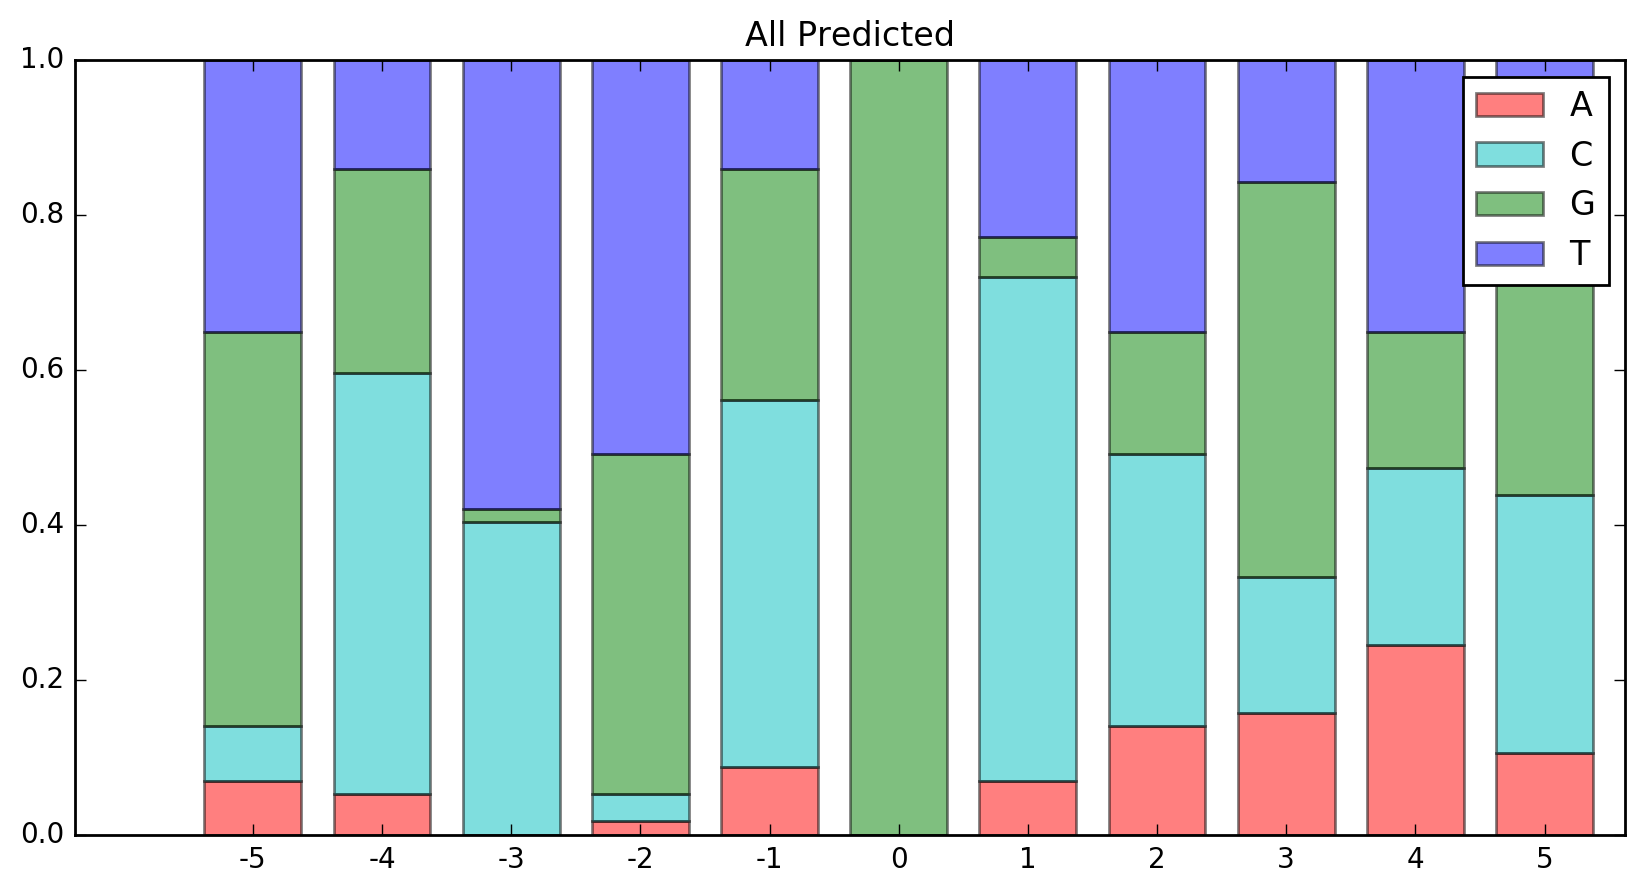

69


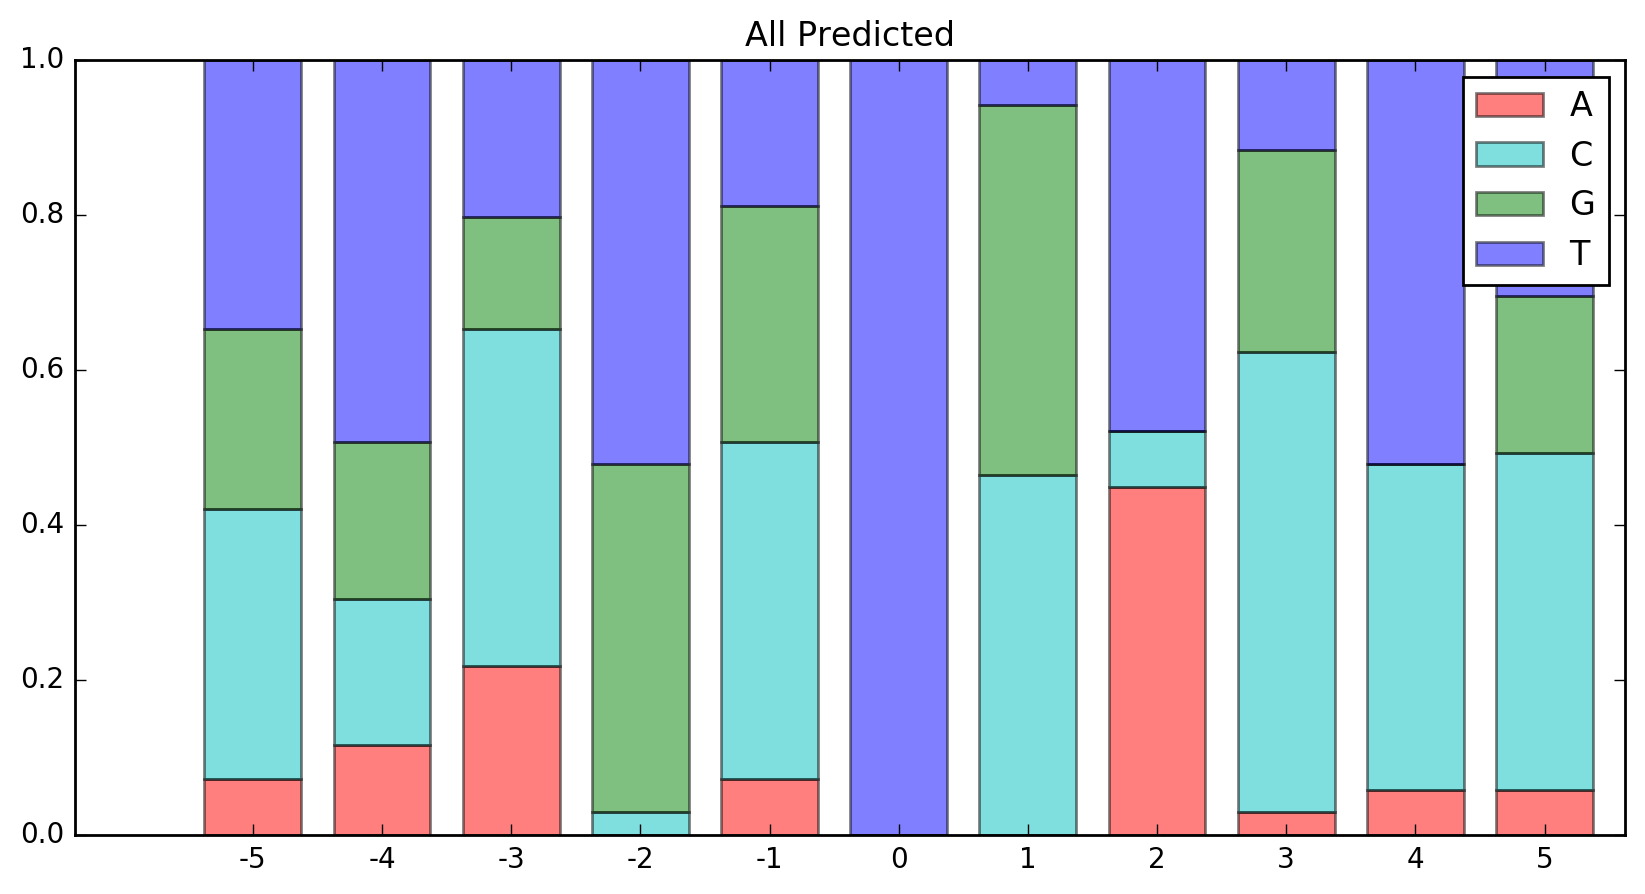

167355


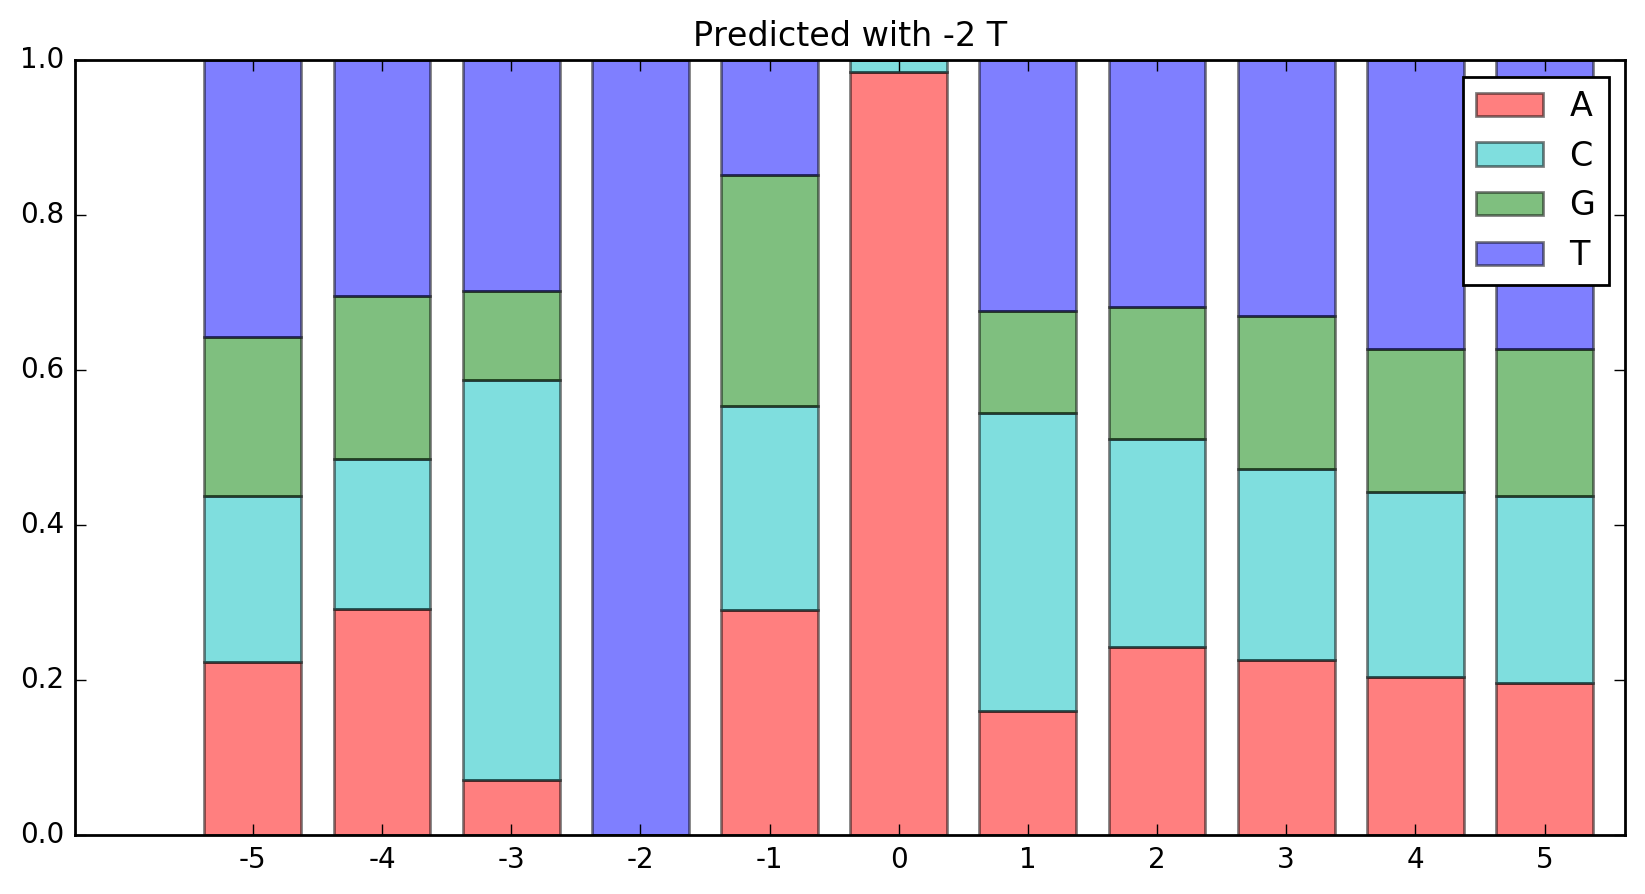

38921


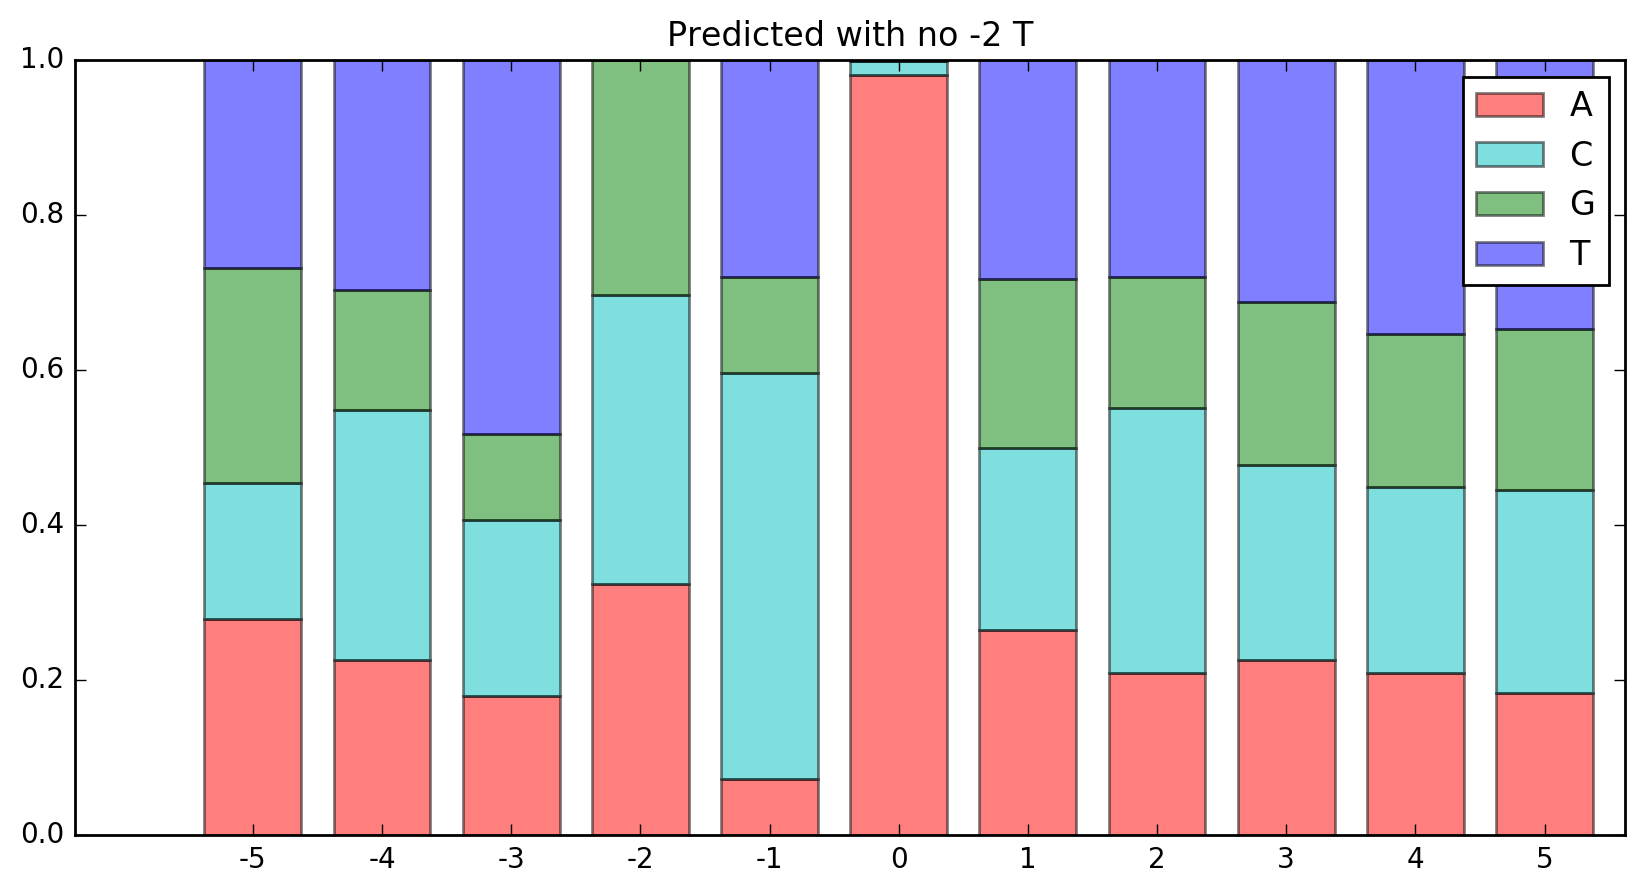

In [20]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        if not seq[bp, i]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, 'All Predicted')

# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'Predicted with -2 T')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'Predicted with no -2 T')

## Variants

In [21]:
from sklearn.utils import shuffle
import pandas
def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../variants/hg19.pathogenicv2.features.tsv')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [22]:
# Make dict of chrom --> pos --> score
from sklearn.utils import shuffle

k_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, y_known):
    if chrom not in k_bps: k_bps[chrom] = {}
    for bp in np.nonzero(pred)[0]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        k_bps[chrom][idx] = strand
        
s_bps = {}
total = 0
thresh = 0
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, y_all):
    bp1 = np.argmax(pred)
    bp2 = np.argmax(np.hstack([pred[:bp1], np.zeros((1,)), pred[bp1+1:]]))
    if abs(bp2-bp1) < 5: continue
    if pred[bp2] < thresh: continue
    if chrom not in s_bps: s_bps[chrom] = {}
    idx = pos + (bp2-L+1 if strand == '+' else L-bp2)
    s_bps[chrom][idx] = strand
    total += 1
print total

r_s_bps = {}
total = 0

for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, shuffle(y_all)):
    bp1 = np.argmax(pred)
    bp2 = np.argmax(np.hstack([pred[:bp1], np.zeros((1,)), pred[bp1+1:]]))
    if abs(bp2-bp1) < 5: continue
    if pred[bp2] < thresh: continue
    
    if chrom not in r_s_bps: r_s_bps[chrom] = {}
    idx = pos + (bp2-L+1 if strand == '+' else L-bp2)
    if idx in s_bps[chrom]: continue
    r_s_bps[chrom][idx] = strand
    total += 1
print total

a_bps = {}
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, y_all):
    if chrom not in a_bps: a_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    a_bps[chrom][idx] = strand
    
r_a_bps = {}
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, shuffle(y_all)):
    if chrom not in r_a_bps: r_a_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    r_a_bps[chrom][idx] = strand
    
n_bps = {}
for chrom, pos, strand, pred in zip(n_chroms, n_coords,
                                    n_strands, y_novel):
    if chrom not in n_bps: n_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    n_bps[chrom][idx] = strand
    
p_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, p_known):
    if chrom not in p_bps: p_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    p_bps[chrom][idx] = strand

76734
75647


Mercer et. al. branchpoints
10:50681659:C 0
16:8898599:G 0
X:153788599:T 0
21:47409500:G 0
11:118959325:C 0
X:107845097:G 0
X:153131293:G 0
2:242680425:G 0
Predictions in Mercer introns
16:8898599:G 0
13:49047470:G 0
13:49047470:C 0
X:153788599:T 0
11:118959790:C 0
13:49047470:T 0
11:118959325:C 0
21:47409500:G 0
2:225368565:C 0
21:47409627:G 0
2:242680425:G 0
Novel predicted branchpoints
2:71817308:G 0
11:5248301:C 0
11:5248301:A 0
11:5248301:G 0
5:127670560:G 0
11:47359371:C 0
11:118958944:G 0
11:64525847:C 0
4:100522736:G 0
2:228168708:G 0
3:14209904:C 0
7:150646165:C 0
X:100609705:G 0
X:100609705:C 0
21:45750232:A 0
X:154227901:A 0
16:89849346:C 0
3:48613354:C 0
11:66620883:C 0
5:148422402:G 0
13:32971007:G 0
X:150572076:T 0
2:189872759:T 0
X:100601671:G 0
2:189872759:G 0
X:150572076:C 0
3:121994640:C 0
1:197097820:C 0
11:17452526:C 0
X:31224814:A 0
18:21137182:A 0
18:21137182:C 0
16:8941558:G 0
16:2138031:G 0
3:48616971:C 0
12:6101204:A 0
X:138619496:G 0
X:138619496:T 0
All predic

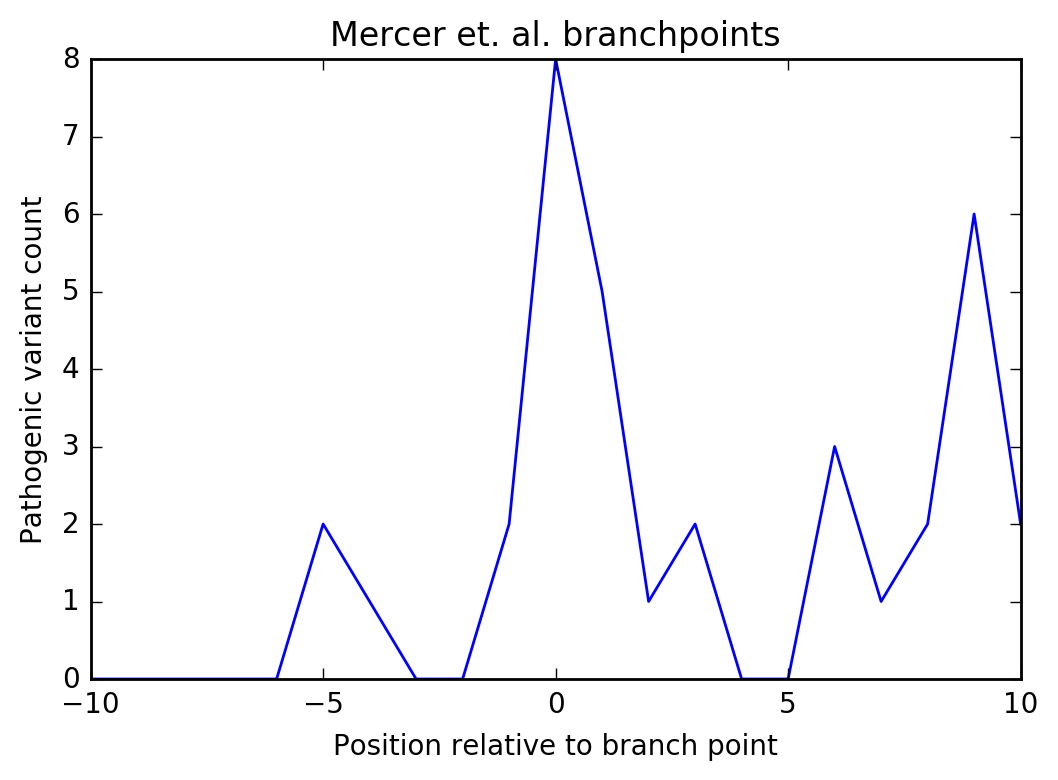

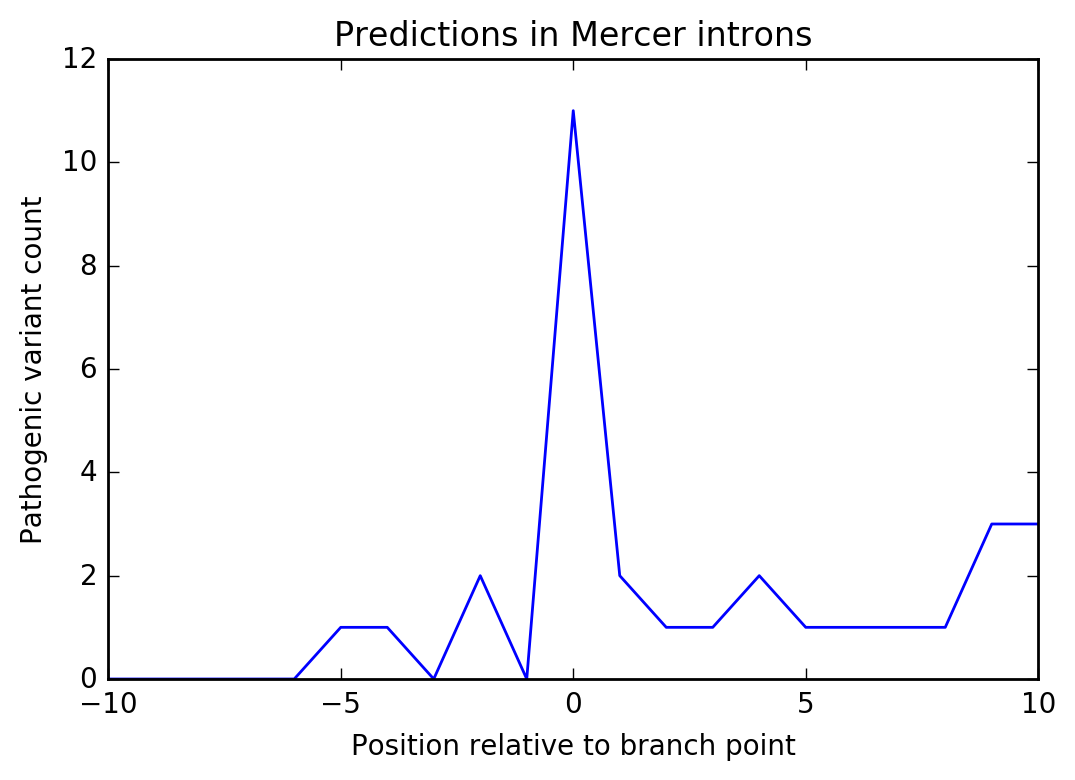

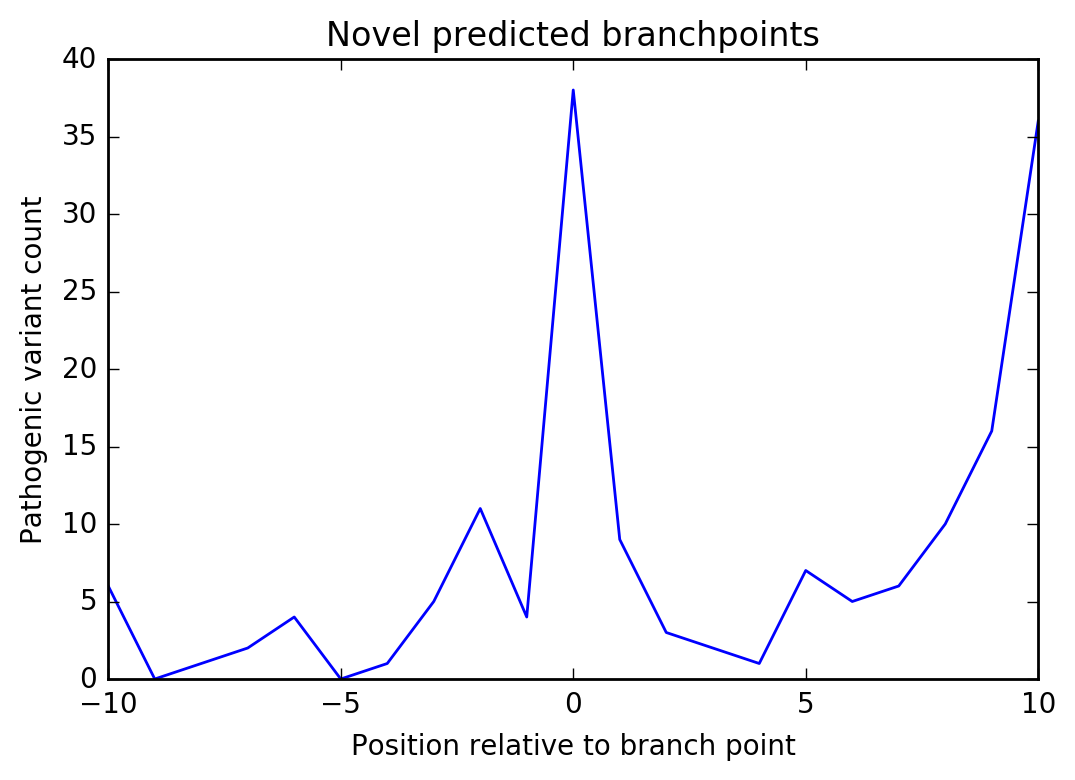

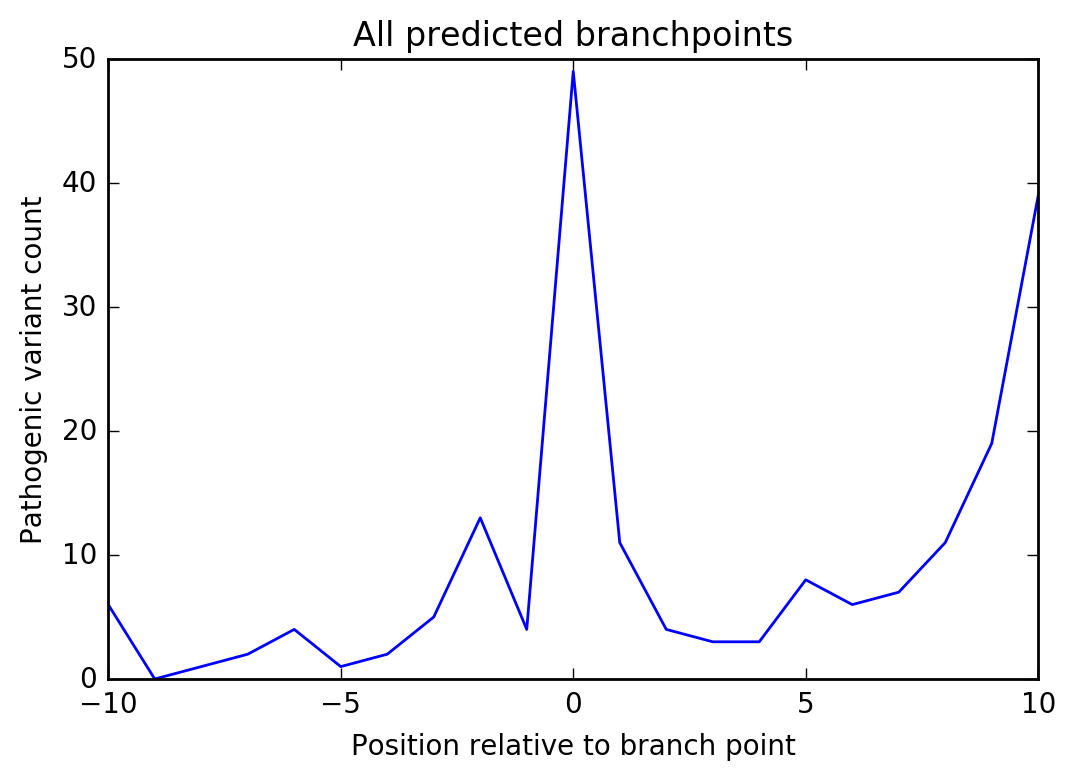

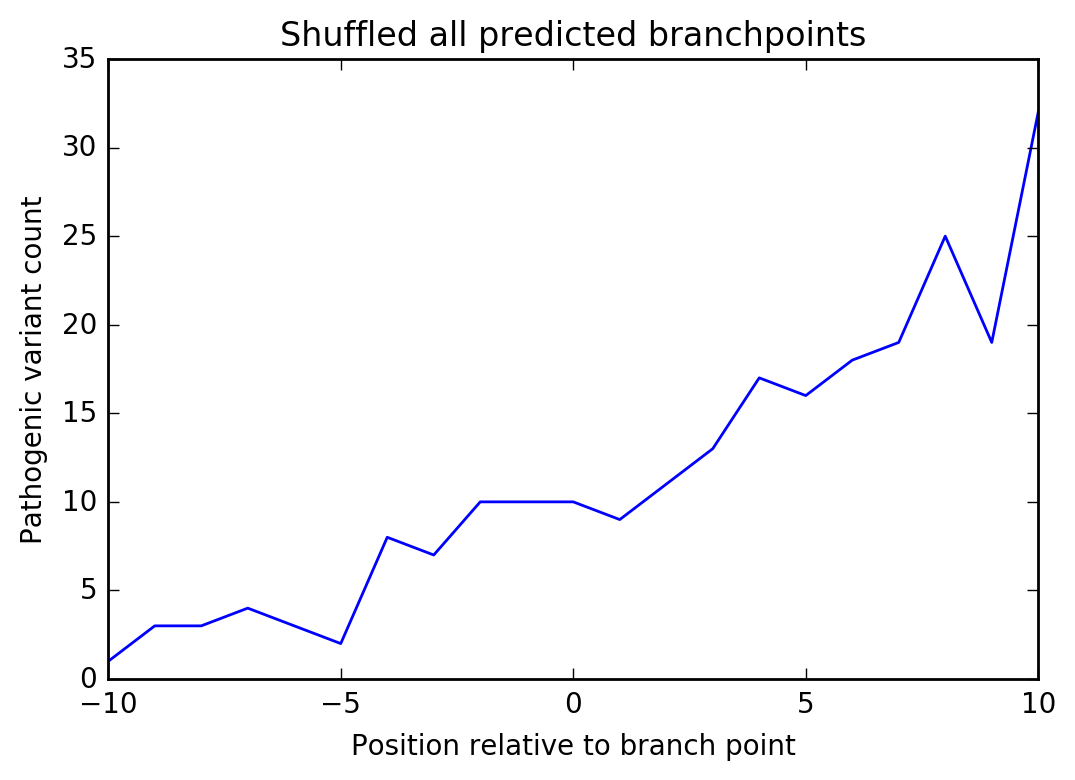

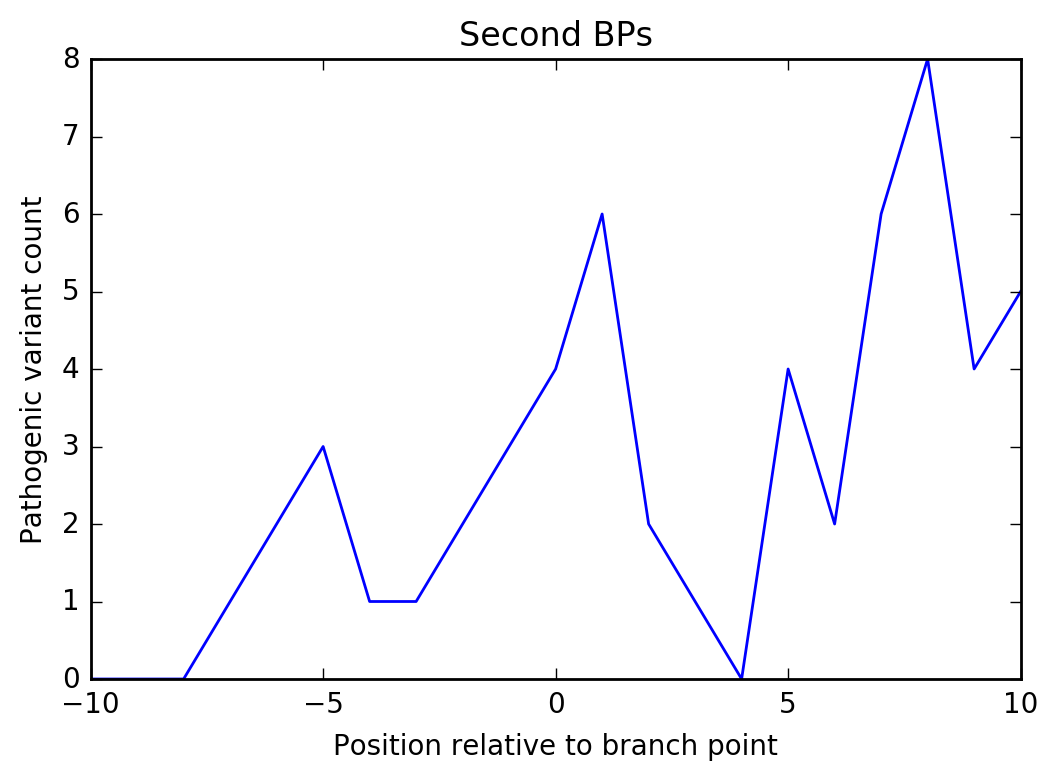

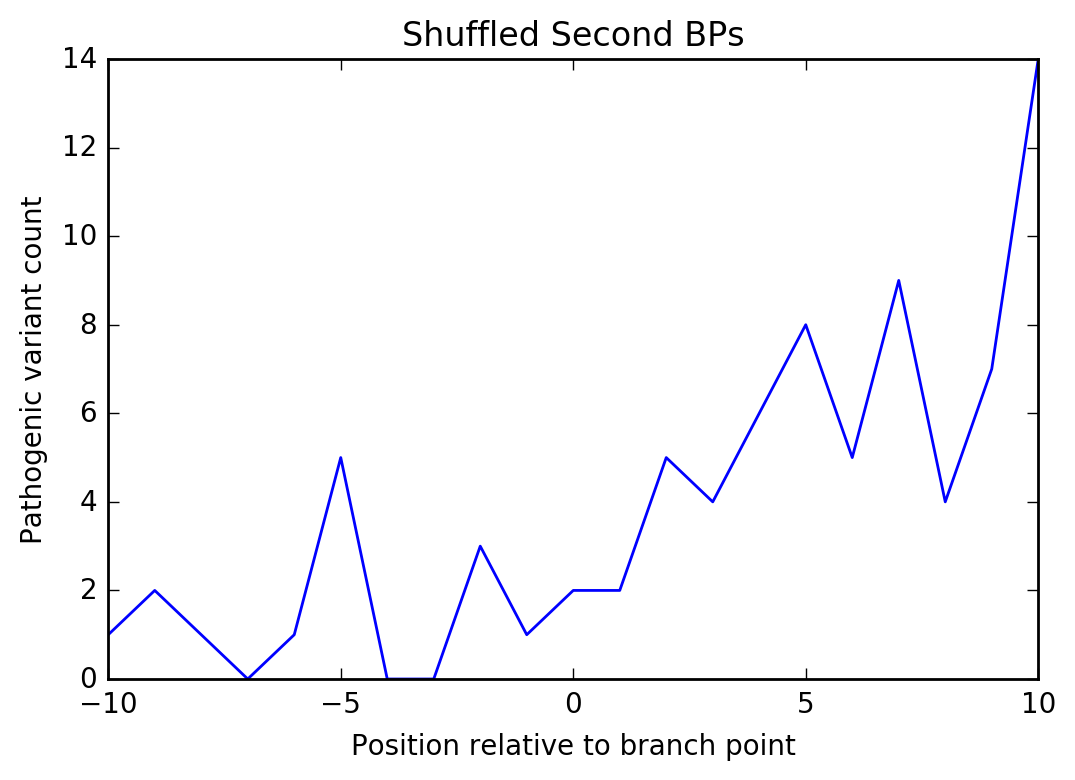

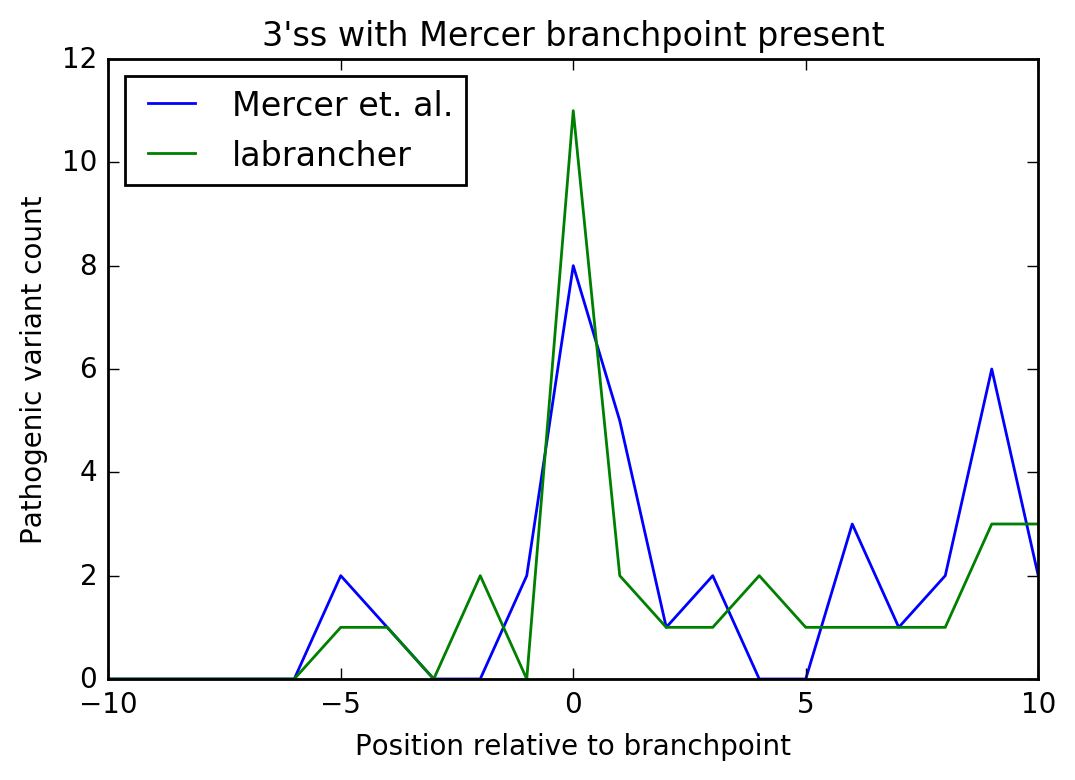

In [23]:
def var_enrichment(v, bps, K = 10):
    hits = []
    variants = {}
    for shift in range(-K, K+1):
        hits += [0]
        for chrom, pos, strand, alt in zip(v['CHROM'], v['POS'], v['strand'], v['ALT']):
            s = -shift if strand == '+' else shift
            key = "{}:{}:{}".format(chrom, pos, alt)
            if 'chr'+str(chrom) not in bps: continue
            if pos+s in bps['chr'+str(chrom)]:
                if key in variants:
                    if abs(variants[key]) <= abs(shift):
                        continue
                    else:
                        hits[-1] += 1
                        hits[variants[key]+K] -= 1
                        variants[key] = shift
                else:
                    hits[-1] += 1
                    variants[key] = shift
    for var, shift in variants.items():
        if not shift:
            print var, shift
    return hits

names = ['Mercer et. al. branchpoints',
         'Predictions in Mercer introns',
         'Novel predicted branchpoints',
         'All predicted branchpoints',
         'Shuffled all predicted branchpoints',
         'Second BPs',
         'Shuffled Second BPs']
bps = [k_bps, p_bps, n_bps, a_bps, r_a_bps, s_bps, r_s_bps]

path = []
for bp, name in zip(bps, names):
    print name
    path += [var_enrichment(pathogenic, bp)]

for name, hits in zip(names, path):
    plt.plot(range(-10, 11), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("Pathogenic variant count")
    plt.show()
    
for name, hits in zip(['Mercer et. al.', 'labrancher'], path)[:2]:
    plt.plot(range(-10, 11), hits, label = name)
plt.title("3'ss with Mercer branchpoint present")
plt.xlabel('Position relative to branchpoint')
plt.ylabel("Pathogenic variant count")
plt.legend(loc = 2)
plt.show()